In [15]:
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps




# Helper function for visualization.
%matplotlib inline
import sys,os
sys.path.append('../')

from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
#from layer2 import GaussianSample


#### Creating a synthetic graph framework to test (a) Edge prediction (b) Robustness and (c) Transferability
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch
import torch_geometric as tg
import pandas as pd

dataset_name = 'Cora'
dataset = Planetoid(root='Planetoid', name=dataset_name, transform=NormalizeFeatures())
###
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



###### geometric properties of the dataset
import numpy as np

nodes = {k:  torch.sum(data.edge_index[0,:] ==k).numpy() for k in np.arange(data.x.shape[0])}

data.edge_index.shape


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


torch.Size([2, 10556])

In [3]:
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx
A = to_scipy_sparse_matrix(data.edge_index)
A2 = A.dot(A)
A3 = A.dot(A2)

In [4]:
### A3: number ofpath of length 3 that connect two nodes
A3.nnz/ data.num_nodes**2 ### still quite sparse


0.04508415352290603

In [5]:
data.edge_weight

In [6]:
#### Compute the edge weights
import torch_geometric.transforms as T
import copy
data = dataset[0]  # Get the first graph object.
data.edge_weight = torch.ones(data.edge_index.shape[1])
transform = T.GDC(
        self_loop_weight=1.,
        normalization_in='row',
        normalization_out='row',
        diffusion_kwargs=dict(method='ppr', alpha=0.2),
        sparsification_kwargs=dict(method='topk', k=30, dim=0),
        exact=True,
    )

data2 = transform(copy.deepcopy(data))
    
    
# edges2, edge_weights = transform(copy.deepcopy(data)).transition_matrix(edge_index=data.edge_index,
#                         edge_weight=torch.ones(data.edge_index.shape[1]),
#                         num_nodes=data.num_nodes, normalization= 'row')
# print(edges2.shape)
# plt.hist(list(edge_weights.numpy()))

In [7]:
data2

Data(x=[2708, 1433], edge_index=[2, 81240], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_weight=[10556], edge_attr=[81240])

(array([7.1742e+04, 4.9150e+03, 1.2630e+03, 3.8000e+02, 5.2300e+02,
        1.3660e+03, 7.0300e+02, 1.9400e+02, 1.4500e+02, 9.0000e+00]),
 array([0.        , 0.06873675, 0.13747351, 0.20621027, 0.27494702,
        0.34368378, 0.41242054, 0.4811573 , 0.54989403, 0.6186308 ,
        0.68736756], dtype=float32),
 <BarContainer object of 10 artists>)

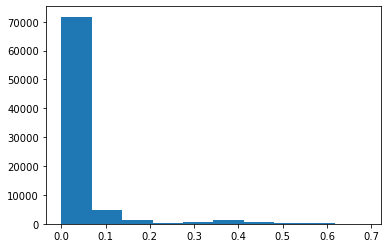

In [8]:
plt.hist(list(data2.edge_attr.numpy())) #### Need to renormalize the distance

In [9]:
newA = to_scipy_sparse_matrix(data2.edge_index, data2.edge_attr) 

In [10]:
def prob_high_dim(sigma, dist):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    d = dist - np.min(dist); d[d < 0] = 0
    return np.exp(- d / sigma)

def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))


def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    Do we really need this?
    """
    sigma_lower_limit = 0; 
    sigma_upper_limit = 100;
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

(array([53595.,  5495.,  3327.,  2410.,  2067.,  1541.,  1333.,  1107.,
          889.,  9476.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

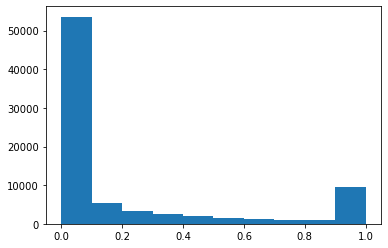

In [11]:
rows = []
cols = []
weights = []
sigmas = []
n_eff_neighbours = []
N_NEIGHBOURS = 20
for u in range(data.num_nodes):
    rows+= list(newA.row[newA.row == u])
    cols+= list(newA.col[newA.row == u])
    #### want to find the appropriate scaling factor
    dist_row = newA.data[newA.row == u]
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOURS) #### Maybe we should have a varying number of neighbours here
    sigmas += [binary_search_result]
    weights += list(prob_high_dim(binary_search_result, dist_row))
    n_eff_neighbours += [k(prob_high_dim(binary_search_result, dist_row))]
plt.hist(weights)

(array([7.1742e+04, 4.9150e+03, 1.2630e+03, 3.8000e+02, 5.2300e+02,
        1.3660e+03, 7.0300e+02, 1.9400e+02, 1.4500e+02, 9.0000e+00]),
 array([0.        , 0.06873675, 0.13747351, 0.20621027, 0.27494702,
        0.34368378, 0.41242054, 0.4811573 , 0.54989403, 0.6186308 ,
        0.68736756], dtype=float32),
 <BarContainer object of 10 artists>)

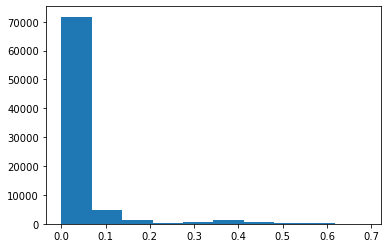

In [12]:
plt.hist(newA.data)

(array([2484.,   23.,   10.,    8.,    0.,    0.,    4.,    7.,    0.,
           3.]),
 array([9.53674316e-05, 1.09119415e-01, 2.18143463e-01, 3.27167511e-01,
        4.36191559e-01, 5.45215607e-01, 6.54239655e-01, 7.63263702e-01,
        8.72287750e-01, 9.81311798e-01, 1.09033585e+00]),
 <BarContainer object of 10 artists>)

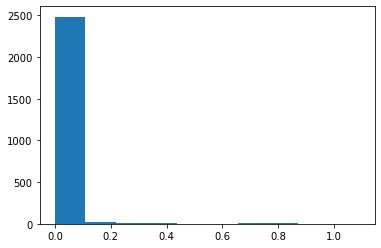

In [13]:
sigmas= np.array(sigmas)
plt.hist(np.array(sigmas)[sigmas<40])

In [14]:
data2.edge_attr


tensor([0.4375, 0.1220, 0.0435,  ..., 0.0020, 0.1241, 0.3620])

In [15]:

# from torch_geometric.utils import add_remaining_self_loops
# from torch_scatter import scatter_add 

# add_self_loops=True
# fill_value = 1
# alpha = 0.5

# edge_index0 = data.edge_index
# edge_weight = torch.ones((edge_index0.size(1), ))


# num_nodes = data.num_nodes
# edge_index, edge_weight = add_remaining_self_loops(
#                 edge_index0, edge_weight, fill_value, num_nodes)

# row, col = edge_index[0], edge_index[1]
# deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
# deg_inv_sqrt = deg.pow_(-alpha)
# deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
# L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
# #L = deg_inv_sqrt[row] * edge_weight #* deg_inv_sqrt[col]
# print(L)
# plt.hist(L.numpy())

In [16]:
# from torch_geometric.utils import to_scipy_sparse_matrix, from_scipy_sparse_matrix
# L = deg_inv_sqrt[row] * edge_weight
# P = to_scipy_sparse_matrix(edge_index, edge_attr=L, num_nodes=data.num_nodes)
# A = P + P.T - P.multiply(P.T)
# d = from_scipy_sparse_matrix(A)
# plt.hist(d[1].numpy())

In [17]:
def prob_low_dim(Y, YY, a=1., b=1.):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = torch.power(1 + a * torch.sum(torch.square(Y-YY))**b, -1)
    return inv_distances

In [18]:
from numbers import Number
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, APPNP
class GCNbis(nn.Module): # in_dim, hid_dims, out_dim, normalize=True
    def __init__(self, input_dim, hidden_dim, output_dim, n_classes, n_layers,
    activation='relu', slope=.1, device='cpu', normalize=True):
        super().__init__()
        self.input_dim = input_dim
        self.n_classes = n_classes 
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.device = device
        self.propagate = APPNP(K=1, alpha=0)
        self.normalize = normalize
        self.logreg = nn.Linear(output_dim, n_classes)
        
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'relu':
                self._act_f.append(lambda x: torch.nn.ReLU()(x))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x, edge_index):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
            else:
                h = self.fc[c](h)
                h = F.dropout(h, p=0.5, training=self.training)
                h = self.propagate(h, edge_index)
                if self.normalize: h = F.normalize(h, p=2, dim=1)
                h = self._act_f[c](h)
        logits = self.logreg(h)
        return h, logits

model = GCNbis(data.num_features, 32, 32, dataset.num_classes, n_layers=2,
                                normalize=True)

In [19]:
from numbers import Number
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, APPNP
class GCNter(nn.Module): # in_dim, hid_dims, out_dim, normalize=True
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, end='linear',
    activation='relu', slope=.1, device='cpu', normalize=True):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.end = end
        self.n_layers = n_layers
        self.device = device
        self.propagate = APPNP(K=1, alpha=0)
        self.normalize = normalize
        
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'relu':
                self._act_f.append(lambda x: torch.nn.ReLU()(x))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x, edge_index):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                if self.end == 'linear': 
                    h = self.fc[c](h)
                else:
                    h = self.propagate(h, edge_index)
            else:
                h = self.fc[c](h)
                h = F.dropout(h, p=0.5, training=self.training)
                h = self.propagate(h, edge_index)
                if self.normalize: h = F.normalize(h, p=2, dim=1)
                h = self._act_f[c](h)
        return h

model = GCNter(data.num_features, 32, 32, n_layers=2, end='propagate',
                                normalize=True)

In [20]:
2

2

In [1]:
model = GCNter(data.num_features, 512, 512, n_layers=2, end='prop',
                                normalize=True)
### we might not want to normalize.
### we might not want to use the dot product as a similarity matrix/
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                                 weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()  

from sklearn.metrics import accuracy_score
from train_utils import *
from scipy import optimize
from torch_geometric.utils import remove_self_loops, negative_sampling

from io_utils.visualisation import *
from carbontracker.tracker import CarbonTracker



training_rate = 0.85
MAX_EPOCH_EVAL = 100
#tracker = CarbonTracker(epochs=MAX_EPOCH_EVAL)
val_ratio = (1.0 - training_rate) / 3
test_ratio = (1.0 - training_rate) / 3 * 2
transform = RandomLinkSplit(num_val=val_ratio, num_test=test_ratio,
                                is_undirected=True, split_labels=True)
transform_nodes = RandomNodeSplit(split = 'test_rest',
                                      num_train_per_class = 20,
                                      num_val = 500)
train_data, val_data, test_data = transform(data)
rand_data = transform_nodes(data)
# MIN_DIST = 1e-1  Worked really well
MIN_DIST = 1.

# add_self_loops=True
# fill_value = 1
# alpha = 0.5

# edge_index0 = data.edge_index
# edge_weight = torch.ones((edge_index0.size(1), ))


# num_nodes = data.num_nodes
# edge_index, edge_weight = add_remaining_self_loops(
#                 edge_index0, edge_weight, fill_value, num_nodes)

# row, col = edge_index[0], edge_index[1]
# deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
# deg_inv_sqrt = deg.pow_(-alpha)
# deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
# L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
# #L = deg_inv_sqrt[row] * edge_weight #* deg_inv_sqrt[col]

# P = to_scipy_sparse_matrix(edge_index, edge_attr=L, num_nodes=data.num_nodes)
# A = P + P.T - P.multiply(P.T)
# d = from_scipy_sparse_matrix(A)#
#edge_weights  = d[1]#0.5 * (1 + d[1])
edge_index = torch.vstack([torch.from_numpy(np.array(rows)),
                          torch.from_numpy(np.array(cols))]).long()
edge_weights = torch.from_numpy(np.array(weights))
print(edge_weights )


plt.figure()
plt.hist(edge_weights.numpy())
plt.show()
MIN_DIST = 1e-1


x = np.linspace(0, 2, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))
EPS = 1e-3


p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
a = p[0]
b = p[1]
print("Hyperparameters a = " + str(a) + " and b = " + str(b))
lbda = 1e-2


for epoch in range(400):
    #tracker.epoch_start()
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    #edge
    #print("out", out)
    # pdb.set_trace()
    #### Evaluate on existing edges
    output_activation = torch.nn.Sigmoid()
    #logits = output_activation(torch.mm(logits_temp, logits_temp.t()))
    #edge = output_activation(torch.mm(logits_temp, logits_temp.t()))
    #### Look for min per node
    #min_dist = 
    ##### Subsample training edges
    #train_index = torch.randperm(data.edge_index.shape[1])[:5000]
    train_index = np.arange(data.edge_index.shape[1]) #dattorch.randperm(data.edge_index.shape[1])#[:1000]
    #train_indices = train_index[row[train_index]!=col[train_index]]
    (row_pos, col_pos), edge_weights_pos = remove_self_loops(edge_index, edge_weights)
    #d = torch.cdist(out[row[train_index]], out[col[train_index]], p=2.0)
    #d_min = torch.sort(d, 1)[0][:,1]
    #### subsample
    indices = torch.randperm(len(row_pos))[:data.edge_index.shape[1]]
    (row_pos, col_pos), edge_weights_pos = (row_pos[indices], col_pos[indices]), edge_weights_pos[indices]
    diff_norm = torch.sum(torch.square(out[row_pos] - out[col_pos]), 1) + EPS
    q =  torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
    q = torch.clamp(q, EPS, 1.-EPS)  ### ensure above 0
    #### Maybe the as and the bs should be node dependent
    #print("q_pos",torch.max(q),  torch.min(q))
    #loss = criterion(q, L[val_indices])
    edge_weights_pos = (1-EPS) * torch.ones((len(row_pos), 1))
    #loss = torch.mean((1-EPS) * torch.ones((len(row_pos), 1)) * (torch.log((1-EPS) * torch.ones((len(row_pos), 1))) - torch.log(q)  ))  +\
    #      torch.mean((EPS) *(torch.ones((len(row_pos), 1))) * (torch.log((EPS) *(torch.ones((len(row_pos), 1)))) - torch.log(1.-q)  )) 
    #loss = torch.mean(q * (-torch.log(edge_weights_pos) + torch.log(q)  ))  + torch.mean((1.-q) * (-torch.log(1.-edge_weights_pos) + torch.log(1.-q)  )) 
    #### add loss 
    loss =  -torch.mean(edge_weights_pos *  torch.log(q)  )  - torch.mean((1.-edge_weights_pos) * (  torch.log(1.-q)  )) 
    #print("loss pos", loss)
    neg_edge_index = negative_sampling(data.edge_index, data.num_nodes, num_neg_samples=1000)
    row_neg, col_neg = neg_edge_index[0], neg_edge_index[1]
# #     loss += criterion(output_activation(torch.sum(out[neg_edge_index[0]] * out[neg_edge_index[1]], 1)), 
# #                       torch.zeros((neg_edge_index.shape[1])))
    diff_norm = torch.sum(torch.square(out[row_neg] - out[col_neg]), 1)+ EPS
    #diff_norm = torch.clamp(diff_norm, EPS, 1.-EPS)  ### ensure above 0
#     #print("diffnorm neg", torch.sum(torch.isnan(diff_norm)), torch.max(diff_norm),  torch.min(diff_norm))
#     #q_neg = torch.exp(-1.0*torch.log(1.  + a * torch.exp(b * torch.log(diff_norm))))
    q_neg = torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
    #### This might still not be good and too high dimensional!
    q_neg = torch.clamp(q_neg, EPS, 1.-EPS)  ### ensure above 0
#     #print("q_neg", torch.max(q_neg),  torch.min(q_neg))
    edge_weights_neg = EPS * torch.ones((neg_edge_index.shape[1], 1))
    loss +=  torch.mean(EPS * ( - torch.log(q_neg)  ))  + torch.mean((1.-EPS) * ( - torch.log(1.-q_neg)  )) 
    loss.backward()
    
    optimizer.step()
    #print("weight", model.fc[0].weight.grad)
    #tracker.epoch_end()
    print('Epoch={:03d}, loss={:.4f}'.format(epoch, loss.item()))
    if epoch % 10 == 0 :
                print("=== Evaluation ===")
                embeds = out
                plt.figure()
                visualize_umap(out, data.y.numpy(), size=30, epoch=None, loss = None)
                plt.show()
                _, res, best_epoch = edge_prediction(embeds.detach(), embeds.shape[1],
                                         train_data, test_data, val_data,
                                         lr=0.01, wd=1e-4,
                                         patience = 30,
                                         max_epochs=MAX_EPOCH_EVAL)
                val_ap, val_roc, test_ap, test_roc, train_ap, train_roc = res[best_epoch][1], res[best_epoch][2], res[best_epoch][3], res[best_epoch][4], res[best_epoch][5], res[best_epoch][6]
                
                _, nodes_res, best_epoch = node_prediction(embeds.detach(),
                                               dataset.num_classes, data.y,
                                               rand_data.train_mask, rand_data.test_mask,
                                               rand_data.val_mask,
                                               lr=0.01, wd=1e-4,
                                               patience = 20,
                                               max_epochs=MAX_EPOCH_EVAL)

                acc_train, val_train, acc = nodes_res[best_epoch][2], nodes_res[best_epoch][3], nodes_res[best_epoch][4]

                _, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                                               dataset.num_classes, data.y,
                                               data.train_mask, data.test_mask,
                                               data.val_mask,
                                               lr=0.05, wd=0,
                                               patience = 200,
                                               max_epochs=MAX_EPOCH_EVAL)
                acc_train_default, acc_val_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3], nodes_res_default[best_epoch][4]
                print(['UMAP', train_roc, train_ap,
                   test_roc, test_ap, acc_train, val_train, acc,
                   acc_train_default, acc_val_default, acc_default, epoch,])
None;

#tracker.stop()
None;

NameError: name 'GCNter' is not defined

In [30]:
!pip install carbontracker

     |████████████████████████████████| 98 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 9.7 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=68ff6d2b705eb83f59269ccdcf2282c852ebb8f1e5f31bc9f841f6452e422137
  Stored in directory: /Users/cdonnat/Library/Caches/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built future


In [382]:
_, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                               dataset.num_classes, data.y,
                               data.train_mask, data.test_mask,
                               data.val_mask,n_layers=1,
                               lr=0.05, wd=1e-6,
                               patience = 2000,
                               max_epochs=30000)
acc_train_default, acc_val_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3], nodes_res_default[best_epoch][4]
print(['ICA', train_roc, train_ap,
   test_roc, test_ap, acc_train, val_train, acc,
   acc_train_default, acc_val_default, acc_default, epoch,])

Early stopping!
Start to test process.
['ICA', 0.9773255518379771, 0.9720203775614179, 0.983876368690342, 0.9792842713762845, 0.800000011920929, tensor(0.7280), 0.761605441570282, 0.8428571224212646, 0.7620000243186951, 0.7761121988296509, 200]


In [319]:
from torch_geometric.utils import (
    add_self_loops,
    negative_sampling,
    remove_self_loops, to_undirected,
     to_dense_adj
)

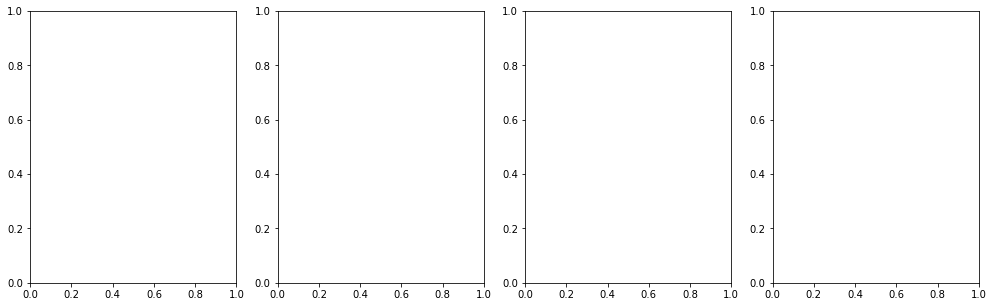

In [29]:
from sklearn.decomposition import PCA
def deg(index, num_nodes = None,           
        dtype = None):
    r"""Computes the (unweighted) degree of a given one-dimensional index tensor.
    Args:
    index (LongTensor): Index tensor.
    num_nodes (int, optional): The number of nodes, *i.e.*
    :obj:`max_val + 1` of :attr:`index`. (default: :obj:`None`)
    dtype (:obj:`torch.dtype`, optional): The desired data type of the
    returned tensor.\n\n    :rtype: :class:`Tensor`\n    """
    if index.shape[0] != 1: # modify input 
        index = index[0] 
    N = num_nodes
    out = torch.zeros((N, ), dtype=dtype, device=index.device)
    one = torch.ones((index.size(0), ), dtype=out.dtype, device=out.device)
    return out.scatter_add_(0, index, one)

out = model(data.x, data.edge_index)
h = (out).detach().cpu().numpy() 
fig, ax = plt.subplots(1, 4, figsize=(17,5))
# hh = PCA(n_components=5).fit_transform((data.x.numpy()))

# ax[0].scatter(hh[:, 0], hh[:, 1], s=30, c=data.y, alpha=0.2, cmap="Set2")    
# ax[0].tick_params(axis='both', labelsize=20)
# ax[0].set_title('PC ' + str(0) + ' vs PC ' +str(1)  + '\n Colored by class', fontdict = {'fontsize':24})
# u = 0
# v = 1
# deg1 = deg(data.edge_index, data.num_nodes)
# hs = ax[1].scatter(h[:, u], h[:, v], s= 100 * np.log(deg(data.edge_index, data.num_nodes).numpy()), 
#             c=np.log(deg1), alpha=0.2, cmap="RdBu")
# # ax[1].legend(loc='ll', label='legend label')  # automatically infer handles and labels
# # ax[1].legend(hs, loc='t', ncols=5, frame=False)  # automatically infer labels from handles

# ax[1].tick_params(axis='both', labelsize=20)
# ax[1].set_title('LC ' + str(u) + ' vs LC ' +str(v)  + '\n Colored by degree', fontdict = {'fontsize':24})


# ax[2].scatter(h[:, u], h[:, v], s= 100 * np.log(deg1.numpy()), 
#             c=data.y.numpy(), alpha=0.2, cmap="Set2")  
# ax[2].tick_params(axis='both', labelsize=20)
# ax[2].set_title('LC ' + str(u) + ' vs LC ' +str(v) + '\n Colored by class', fontdict = {'fontsize':24})
# hs3 = ax[3].scatter(h[:, 2], h[:, 3], s= 100 * np.log(deg1.numpy()), 
#             c=np.log(deg1), alpha=0.1, cmap="RdBu") 
# ax[3].set_title('LC ' + str(2) + ' vs LC ' +str(3) + '\n Colored by degree', fontdict = {'fontsize':24})
# ax[3].tick_params(axis='both', labelsize=20)
# # ax[4].scatter(h[:, 2], h[:, 3], s= 100 * np.log(deg(data.edge_index).numpy()), 
# #             c=labels, alpha=0.2, cmap="Set2")  
# # ax[4].tick_params(axis='both', labelsize=20)
# # ax[4].set_title('LC ' + str(2) + ' vs LC ' +str(3) + '\n Colored by class', fontdict = {'fontsize':24})
# cbar = fig.colorbar(hs, ax=ax[1])
# cbar.ax.tick_params(labelsize=20) 
# cbar2 =fig.colorbar(hs3, ax=ax[3])
# cbar2.ax.tick_params(labelsize=20) 
# #fig.suptitle('Accuracy in classification task: %.2f'%test_acc_list[-1],  fontsize=20)
# plt.tight_layout();
# plt.show()

In [321]:
out, scores = model(data.x, data.edge_index)

In [322]:
scores.shape

torch.Size([2708, 7])

In [323]:
model = GCNbis(data.num_features, 32, 32, dataset.num_classes, n_layers=2,
                                normalize=True)

In [401]:
### We need to dpat the distances appropriately

def node_prediction(embeds, out_dim, y, train_mask, test_mask, val_mask,
                    lr=0.01, wd=1e-4, n_layers =1,
                    patience = 30, max_epochs=3000):
    #input_dim, hidden_dim, output_dim, n_layers=2, activation='relu', slope=.1, device='cpu', use_bn=False
    node_classifier = MLP(embeds.shape[1], embeds.shape[1], out_dim,  n_layers=1)
    #node_classifier = LogReg(embeds.shape[1], out_dim)
    train_labels = y[train_mask]
    test_labels = y[test_mask]
    val_labels = y[val_mask]
    optimizer_temp = torch.optim.Adam(node_classifier.parameters(), lr=lr, weight_decay=wd)
    res_temp = []
    trigger_times = 0
    last_acc = 0
    best_epoch = 0
    loss_fn = torch.nn.MultiMarginLoss(p=1, margin=1, weight=None, size_average=None, reduce=None, reduction='mean')
    for epoch_temp in range(max_epochs):
        node_classifier.train();
        optimizer_temp.zero_grad();
        out = node_classifier(embeds);
        loss_temp = loss_fn (out[train_mask], train_labels);
        loss_temp.backward()
        optimizer_temp.step()

        preds = torch.argmax(out, dim=1)
        acc_train = torch.sum(preds[train_mask] == train_labels).float() / train_labels.shape[0]
        acc = torch.sum(preds[test_mask] == test_labels).float() / test_labels.shape[0]
        val_acc = torch.sum(preds[val_mask] == val_labels).float() / val_labels.shape[0]
        res_temp += [[epoch_temp, loss_temp.cpu().item(), acc_train.item(), val_acc.item() ,  acc.item()]]


        current_acc = val_acc
        if current_acc <= last_acc:
            trigger_times += 1
            #print('Trigger Times:', trigger_times)
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
        else:
            #print('trigger times: 0')
            trigger_times = 0
            last_acc = current_acc
            best_epoch = epoch_temp

    return(node_classifier, res_temp, best_epoch)
_, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                               dataset.num_classes, data.y,
                               data.train_mask, data.test_mask,
                               data.val_mask,n_layers=1,
                               lr=0.05, wd=0,
                               patience = 2000,
                               max_epochs=30000)
acc_train_default, acc_val_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3], nodes_res_default[best_epoch][4]
print(['ICA', train_roc, train_ap,
   test_roc, test_ap, acc_train, val_train, acc,
   acc_train_default, acc_val_default, acc_default, epoch,])


Early stopping!
Start to test process.
['ICA', 0.9773255518379771, 0.9720203775614179, 0.983876368690342, 0.9792842713762845, 0.800000011920929, tensor(0.7280), 0.761605441570282, 0.8357142806053162, 0.7580000162124634, 0.7707930207252502, 200]


In [325]:
torch.vstack([torch.from_numpy(np.array(rows)),
                          torch.from_numpy(np.array(cols))]).shape

torch.Size([2, 81240])

tensor([0.0779, 0.5426, 0.9852,  ..., 0.0795, 0.0000, 0.0000])


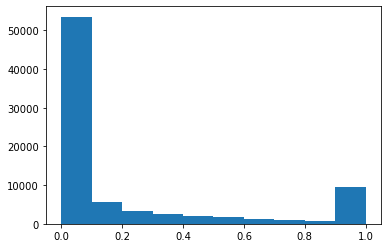

Hyperparameters a = 1.5295919329483947 and b = 0.8443373647932322
Epoch=000, loss=2.0103
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

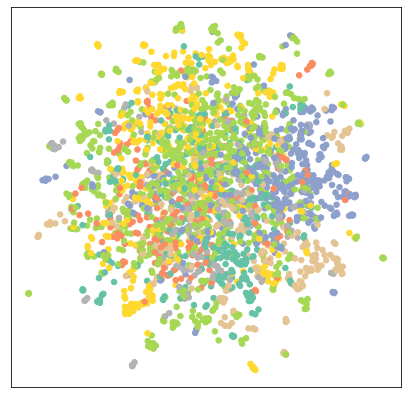

Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9079362405511548, 0.9092989836547835, 0.8975818153667784, 0.8928165465102353, 0.7857142686843872, tensor(0.3540), 0.32350096106529236, 0.8714285492897034, tensor(0.3060), 0.30029013752937317, 0]
Epoch=001, loss=1.8835
Epoch=002, loss=1.7820
Epoch=003, loss=1.7217
Epoch=004, loss=1.6644
Epoch=005, loss=1.6242
Epoch=006, loss=1.5757
Epoch=007, loss=1.5639
Epoch=008, loss=1.5343
Epoch=009, loss=1.4944
Epoch=010, loss=1.4926
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

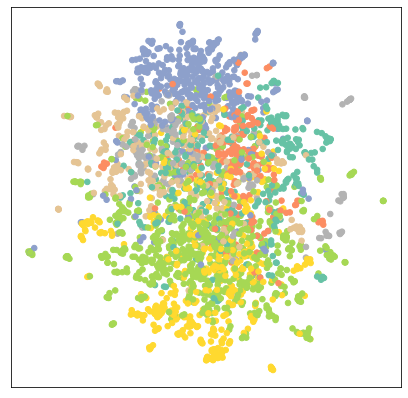

Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9480900841539014, 0.9464643733448369, 0.9442604121283698, 0.9436353135672727, 0.9142857193946838, tensor(0.3940), 0.4037717580795288, 0.9785714149475098, tensor(0.4440), 0.4501934349536896, 10]
Epoch=011, loss=1.4697
Epoch=012, loss=1.4469
Epoch=013, loss=1.4454
Epoch=014, loss=1.4226
Epoch=015, loss=1.4146
Epoch=016, loss=1.3823
Epoch=017, loss=1.3740
Epoch=018, loss=1.3619
Epoch=019, loss=1.3366
Epoch=020, loss=1.3080
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

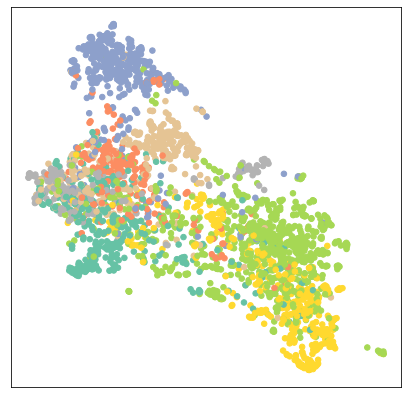

Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9096143389700719, 0.8938411833930179, 0.87421551224395, 0.8307585157237851, 0.8142856955528259, tensor(0.6240), 0.613152801990509, 0.8571428656578064, tensor(0.6520), 0.6441006064414978, 20]
Epoch=021, loss=1.2849
Epoch=022, loss=1.2679
Epoch=023, loss=1.2372
Epoch=024, loss=1.2143
Epoch=025, loss=1.1862
Epoch=026, loss=1.1725
Epoch=027, loss=1.1644
Epoch=028, loss=1.1472
Epoch=029, loss=1.1291
Epoch=030, loss=1.1210
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

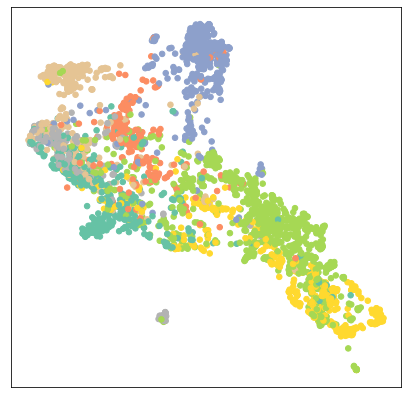

Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.8850565014330154, 0.8603624957542595, 0.8531878197811535, 0.8180652504344729, 0.8285714387893677, tensor(0.7060), 0.7055125832557678, 0.9785714149475098, tensor(0.7120), 0.7306576371192932, 30]
Epoch=031, loss=1.1273
Epoch=032, loss=1.1145
Epoch=033, loss=1.1221
Epoch=034, loss=1.1111
Epoch=035, loss=1.1027
Epoch=036, loss=1.1233
Epoch=037, loss=1.1064
Epoch=038, loss=1.0910
Epoch=039, loss=1.0663
Epoch=040, loss=1.0702
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

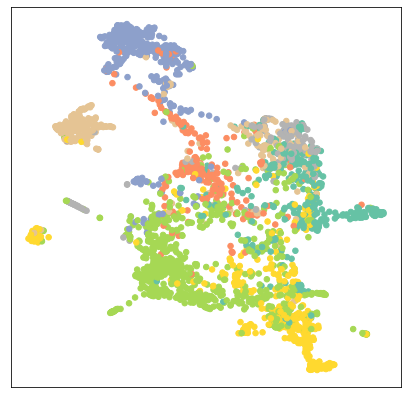

Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9542179571350499, 0.9460723900897464, 0.9267235326523338, 0.9059356031528669, 0.8285714387893677, tensor(0.7280), 0.7412959337234497, 0.7857142686843872, tensor(0.7260), 0.7325918674468994, 40]
Epoch=041, loss=1.0742
Epoch=042, loss=1.0474
Epoch=043, loss=1.0440
Epoch=044, loss=1.0231
Epoch=045, loss=1.0177
Epoch=046, loss=1.0248
Epoch=047, loss=1.0196
Epoch=048, loss=0.9940
Epoch=049, loss=0.9970
Epoch=050, loss=0.9927
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

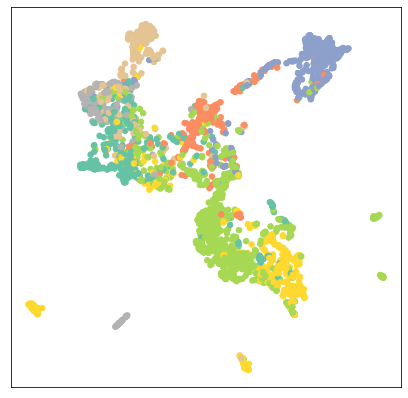

Early stopping!
Start to test process.
['ICA', 0.95071185073446, 0.9411786576710439, 0.9244407317925027, 0.903128604963479, 0.8857142925262451, tensor(0.7780), 0.7703094482421875, 0.9714285731315613, tensor(0.7820), 0.7799806594848633, 50]
Epoch=051, loss=0.9798
Epoch=052, loss=0.9700
Epoch=053, loss=0.9600
Epoch=054, loss=0.9543
Epoch=055, loss=0.9548
Epoch=056, loss=0.9617
Epoch=057, loss=0.9388
Epoch=058, loss=0.9297
Epoch=059, loss=0.9028
Epoch=060, loss=0.8965
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

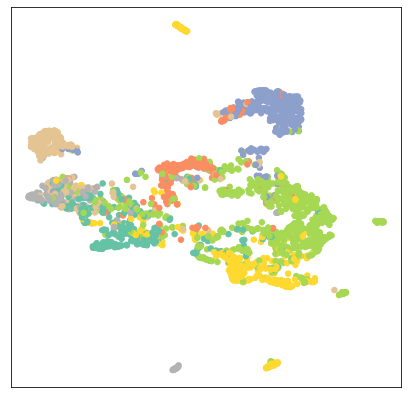

Early stopping!
Start to test process.
['ICA', 0.9449941376647889, 0.93186522572295, 0.9242282944885122, 0.9007717156957009, 0.8500000238418579, tensor(0.7640), 0.7732108235359192, 0.8571428656578064, tensor(0.7660), 0.7765957713127136, 60]
Epoch=061, loss=0.9035
Epoch=062, loss=0.8809
Epoch=063, loss=0.8697
Epoch=064, loss=0.8809
Epoch=065, loss=0.8703
Epoch=066, loss=0.8781
Epoch=067, loss=0.8825
Epoch=068, loss=0.8445
Epoch=069, loss=0.8446
Epoch=070, loss=0.8618
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

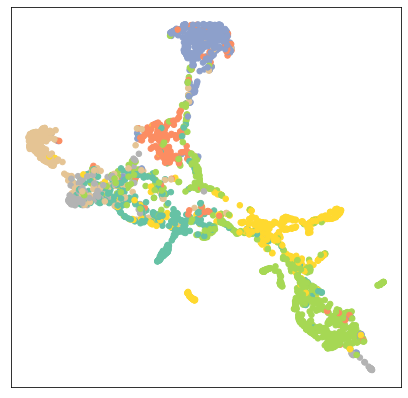

Early stopping!
Start to test process.
['ICA', 0.9387799779407793, 0.9251724520288611, 0.9285526538460153, 0.9132709942621778, 0.8357142806053162, tensor(0.7680), 0.7587040662765503, 0.8500000238418579, tensor(0.7800), 0.7698259353637695, 70]
Epoch=071, loss=0.8415
Epoch=072, loss=0.8420
Epoch=073, loss=0.8618
Epoch=074, loss=0.8257
Epoch=075, loss=0.8363
Epoch=076, loss=0.8244
Epoch=077, loss=0.8254
Epoch=078, loss=0.8478
Epoch=079, loss=0.8226
Epoch=080, loss=0.8115
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

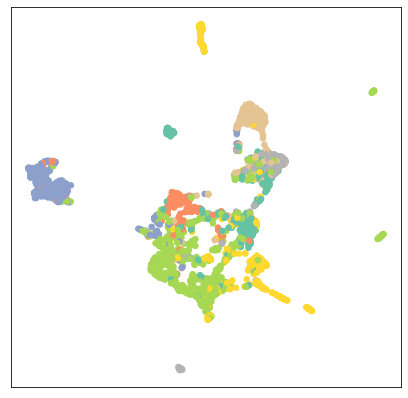

Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9341280153691681, 0.9193198426597025, 0.9190073776955233, 0.8989738189720013, 0.7785714268684387, tensor(0.7700), 0.7509671449661255, 0.8285714387893677, tensor(0.7860), 0.7669245600700378, 80]
Epoch=081, loss=0.8051
Epoch=082, loss=0.8107
Epoch=083, loss=0.8042
Epoch=084, loss=0.8041
Epoch=085, loss=0.8110
Epoch=086, loss=0.7927
Epoch=087, loss=0.7821
Epoch=088, loss=0.7863
Epoch=089, loss=0.7898
Epoch=090, loss=0.8056
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

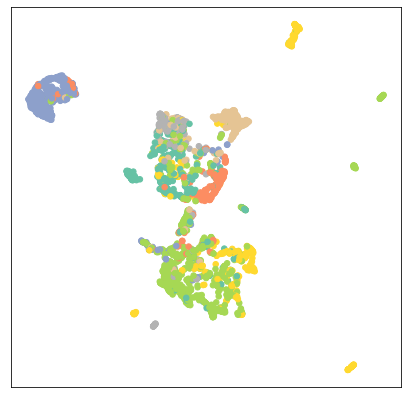

Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9297267708939028, 0.9148330490655406, 0.9173978950703743, 0.8974074544560976, 0.7642857432365417, tensor(0.7500), 0.7393617033958435, 0.7857142686843872, tensor(0.7460), 0.7374274730682373, 90]
Epoch=091, loss=0.7936
Epoch=092, loss=0.7899
Epoch=093, loss=0.7781
Epoch=094, loss=0.7808


KeyboardInterrupt: 

In [353]:
model = GCNbis(data.num_features, 512, 512, dataset.num_classes, n_layers=2,
                                normalize=True)
### we might not want to normalize.
### we might not want to use the dot product as a similarity matrix/
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                                 weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()  
from models.baseline_models import LogReg
from sklearn.metrics import accuracy_score
from train_utils import *
from scipy import optimize

training_rate = 0.85
MAX_EPOCH_EVAL = 100
val_ratio = (1.0 - training_rate) / 3
test_ratio = (1.0 - training_rate) / 3 * 2
transform = RandomLinkSplit(num_val=val_ratio, num_test=test_ratio,
                                is_undirected=True, split_labels=True)
transform_nodes = RandomNodeSplit(split = 'test_rest',
                                      num_train_per_class = 20,
                                      num_val = 500)
train_data, val_data, test_data = transform(data)
rand_data = transform_nodes(data)
MIN_DIST = 1e-1


# add_self_loops=True
# fill_value = 1
# alpha = 0.5

# edge_index0 = data.edge_index
# edge_weight = torch.ones((edge_index0.size(1), ))


# num_nodes = data.num_nodes
# edge_index, edge_weight = add_remaining_self_loops(
#                 edge_index0, edge_weight, fill_value, num_nodes)

# row, col = edge_index[0], edge_index[1]
# deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
# deg_inv_sqrt = deg.pow_(-alpha)
# deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
# L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
# #L = deg_inv_sqrt[row] * edge_weight #* deg_inv_sqrt[col]

# P = to_scipy_sparse_matrix(edge_index, edge_attr=L, num_nodes=data.num_nodes)
# A = P + P.T - P.multiply(P.T)
# d = from_scipy_sparse_matrix(A)#
#edge_weights  = d[1]#0.5 * (1 + d[1])
edge_index = torch.vstack([torch.from_numpy(np.array(rows)),
                          torch.from_numpy(np.array(cols))]).long()
edge_weights = torch.from_numpy(np.array(weights))
print(edge_weights )

plt.figure()
plt.hist(edge_weights.numpy())
plt.show()
MIN_DIST = 1e-1

x = np.linspace(0, 2, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))
EPS = 1e-3


p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
a = p[0]
b = p[1]
print("Hyperparameters a = " + str(a) + " and b = " + str(b))
lbda = 1e-2


for epoch in range(400):
    model.train()
    optimizer.zero_grad()

    out, scores = model(data.x, data.edge_index)
    #edge
    #print("out", out)
    # pdb.set_trace()
    #### Evaluate on existing edges
    output_activation = torch.nn.Sigmoid()
    #logits = output_activation(torch.mm(logits_temp, logits_temp.t()))
    #edge = output_activation(torch.mm(logits_temp, logits_temp.t()))
    #### Look for min per node
    #min_dist = 
    ##### Subsample training edges
    #train_index = torch.randperm(data.edge_index.shape[1])[:5000]
    train_index = np.arange(data.edge_index.shape[1]) #dattorch.randperm(data.edge_index.shape[1])#[:1000]
    #train_indices = train_index[row[train_index]!=col[train_index]]
    (row_pos, col_pos), edge_weights_pos = remove_self_loops(edge_index, edge_weights)
    #d = torch.cdist(out[row[train_index]], out[col[train_index]], p=2.0)
    #d_min = torch.sort(d, 1)[0][:,1]
    #### subsample
    indices = torch.randperm(len(row_pos))[:data.edge_index.shape[1]]
    (row_pos, col_pos), edge_weights_pos = (row_pos[indices], col_pos[indices]), edge_weights_pos[indices]
    diff_norm = torch.sum(torch.square(out[row_pos] - out[col_pos]), 1) + EPS
    q =  torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
    q = torch.clamp(q, EPS, 1.-EPS)  ### ensure above 0
    #### Maybe the as and the bs should be node dependent
    #print("q_pos",torch.max(q),  torch.min(q))
    #loss = criterion(q, L[val_indices])
    edge_weights_pos = (1-EPS) * torch.ones((len(row_pos), 1))
    #loss = torch.mean((1-EPS) * torch.ones((len(row_pos), 1)) * (torch.log((1-EPS) * torch.ones((len(row_pos), 1))) - torch.log(q)  ))  +\
    #      torch.mean((EPS) *(torch.ones((len(row_pos), 1))) * (torch.log((EPS) *(torch.ones((len(row_pos), 1)))) - torch.log(1.-q)  )) 
    #loss = torch.mean(q * (-torch.log(edge_weights_pos) + torch.log(q)  ))  + torch.mean((1.-q) * (-torch.log(1.-edge_weights_pos) + torch.log(1.-q)  )) 
    #### add loss 
    loss =  -torch.mean(edge_weights_pos *  torch.log(q)  )  - torch.mean((1.-edge_weights_pos) * (  torch.log(1.-q)  )) 
    #print("loss pos", loss)
    neg_edge_index = negative_sampling(data.edge_index, data.num_nodes, num_neg_samples=1000)
    row_neg, col_neg = neg_edge_index[0], neg_edge_index[1]
# #     loss += criterion(output_activation(torch.sum(out[neg_edge_index[0]] * out[neg_edge_index[1]], 1)), 
# #                       torch.zeros((neg_edge_index.shape[1])))
    diff_norm = torch.sum(torch.square(out[row_neg] - out[col_neg]), 1)+ EPS
    #diff_norm = torch.clamp(diff_norm, EPS, 1.-EPS)  ### ensure above 0
#     #print("diffnorm neg", torch.sum(torch.isnan(diff_norm)), torch.max(diff_norm),  torch.min(diff_norm))
#     #q_neg = torch.exp(-1.0*torch.log(1.  + a * torch.exp(b * torch.log(diff_norm))))
    q_neg = torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
    #### This might still not be good and too high dimensional!
    q_neg = torch.clamp(q_neg, EPS, 1.-EPS)  ### ensure above 0
#     #print("q_neg", torch.max(q_neg),  torch.min(q_neg))
    edge_weights_neg = EPS * torch.ones((neg_edge_index.shape[1], 1))
    loss +=  torch.mean(EPS * ( - torch.log(q_neg)  ))  + torch.mean((1.-EPS) * ( - torch.log(1.-q_neg)  )) 
    loss.backward()
    
    optimizer.step()
    #print("weight", model.fc[0].weight.grad)

    print('Epoch={:03d}, loss={:.4f}'.format(epoch, loss.item()))
    if epoch % 10 == 0 :
                print("=== Evaluation ===")
                embeds = out
                plt.figure()
                visualize_umap(out, data.y.numpy(), size=30, epoch=None, loss = None)
                plt.show()
                _, res, best_epoch = edge_prediction(embeds.detach(), embeds.shape[1],
                                         train_data, test_data, val_data,
                                         lr=0.01, wd=1e-4,
                                         patience = 30,
                                         max_epochs=MAX_EPOCH_EVAL)
                val_ap, val_roc, test_ap, test_roc, train_ap, train_roc = res[best_epoch][1], res[best_epoch][2], res[best_epoch][3], res[best_epoch][4], res[best_epoch][5], res[best_epoch][6]
                
                _, nodes_res, best_epoch = node_prediction(embeds.detach(),
                                               dataset.num_classes, data.y,
                                               rand_data.train_mask, rand_data.test_mask,
                                               rand_data.val_mask,
                                               lr=0.01, wd=1e-4,
                                               patience = 20,
                                               max_epochs=MAX_EPOCH_EVAL)

                acc_train, val_train, acc = nodes_res[best_epoch][2], nodes_res[best_epoch][3], nodes_res[best_epoch][4]

                _, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                                               dataset.num_classes, data.y,
                                               data.train_mask, data.test_mask,
                                               data.val_mask,
                                               lr=0.05, wd=1e-4,
                                               patience = 20,
                                               max_epochs=MAX_EPOCH_EVAL)
                acc_train_default, acc_val_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3], nodes_res_default[best_epoch][4]
                print(['ICA', train_roc, train_ap,
                   test_roc, test_ap, acc_train, val_train, acc,
                   acc_train_default, acc_val_default, acc_default, epoch,])
None;

None;

In [332]:
torch.randperm(1500)[:1000]

tensor([1267, 1350,  710,  177, 1087,  566,  816,  703,  162,  736,  911,  231,
        1192,  974,  762,   40,  246,  494, 1157,  378,  561,  910,  521, 1427,
         919,  120, 1466, 1383,  492,  628, 1286, 1354,   52,  964,  261, 1341,
         254,  753, 1292,  693, 1431,  518,  133,  333,  178, 1254, 1475,  860,
         966,  302,  435,  901,  621,  299, 1027,  181, 1368,   43,  276, 1312,
         602, 1359, 1009,  303,  478,  205,  850, 1356,  483,  998, 1299,  461,
          20,  377, 1452,  821, 1396, 1193, 1135,  743, 1218,  157, 1250,  239,
         649, 1374, 1091,  329,  635,   98,  712, 1336,  555,  819, 1471,  775,
        1339,  957,  174, 1165, 1239,  380,  506,  793,  917,  249, 1067, 1361,
         798,  764, 1216,  932,  341,  240,   45,  543,  760,  563,  500,  307,
         730, 1024, 1028, 1422,  892,  840,   67,  751,  117, 1410, 1485, 1195,
        1036,   13,  288,  270, 1349,  913,  781,  385,  277, 1083,  525,  797,
         902, 1052,  994, 1366, 1050,  1

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

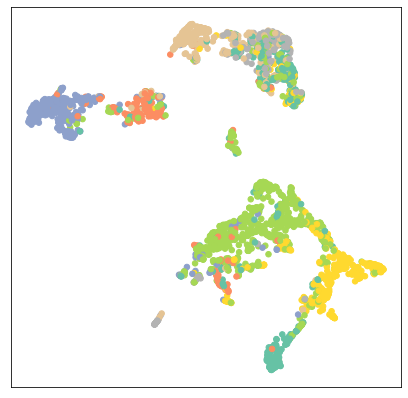

['ICA', 0.9304336966313022, 0.9151763876117427, 0.9385912166176381, 0.9317087351508258, 0.7071428298950195, 0.7080000042915344, 0.699999988079071, 0.717117965221405, 209]


In [350]:
embeds = out
plt.figure()
visualize_umap(out, data.y.numpy(), size=30, epoch=None, loss = None)
plt.show()
_, res, best_epoch = edge_prediction(embeds.detach(), embeds.shape[1],
                         train_data, test_data, val_data,
                         lr=0.01, wd=1e-4,
                         patience = 10,
                         max_epochs=MAX_EPOCH_EVAL)
val_ap, val_roc, test_ap, test_roc, train_ap, train_roc = res[best_epoch][1], res[best_epoch][2], res[best_epoch][3], res[best_epoch][4], res[best_epoch][5], res[best_epoch][6]

_, nodes_res, best_epoch = node_prediction(embeds.detach(),
                               dataset.num_classes, data.y,
                               rand_data.train_mask, rand_data.test_mask,
                               rand_data.val_mask,
                               lr=0.01, wd=1e-4,
                               patience = 20,
                               max_epochs=MAX_EPOCH_EVAL)

acc_train, acc = nodes_res[best_epoch][2], nodes_res[best_epoch][3]

_, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                               dataset.num_classes, data.y,
                               data.train_mask, data.test_mask,
                               data.val_mask,
                               lr=0.005, wd=0,
                               patience = 20,
                               n_layers=1,
                               max_epochs=MAX_EPOCH_EVAL)
acc_train_default,acc_val_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3], nodes_res_default[best_epoch][4]
print(['ICA', train_roc, train_ap,
   test_roc, test_ap, acc_train, acc,
   acc_train_default, acc_default, epoch,])


In [339]:
print(['ICA', train_roc, train_ap,
   test_roc, test_ap, acc_train, acc,
   acc_train_default, acc_default, epoch,])

['ICA', 0.930621784850709, 0.9154216366644532, 0.9382923641391427, 0.930520505377256, 0.7142857313156128, tensor(0.7060), 0.75, 0.7079303860664368, 209]


In [349]:
_, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                               dataset.num_classes, data.y,
                               data.train_mask, data.test_mask,
                               data.val_mask,
                               lr=0.01, wd=1e-4,
                               patience = 100,
                               n_layers=1,
                               max_epochs=MAX_EPOCH_EVAL)
acc_train_default,acc_val_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3],  nodes_res_default[best_epoch][4]
print(['ICA', 
   acc_train_default,acc_val_default, acc_default, epoch,])

['ICA', 0.7142857313156128, 0.7120000123977661, 0.7142166495323181, 209]


In [343]:
def node_prediction(embeds, out_dim, y, train_mask, test_mask, val_mask,
                    lr=0.01, wd=1e-4,  n_layers=1,
                    patience = 30, max_epochs=3000):
    #input_dim, hidden_dim, output_dim, n_layers=2, activation='relu', slope=.1, device='cpu', use_bn=False
    #node_classifier = MLP(embeds.shape[1], embeds.shape[1], out_dim,  n_layers=1)
    if n_layers > 1:
        node_classifier = MLP(embeds.shape[1], int(np.max([int(embeds.shape[1])/2, out_dim])), out_dim,  n_layers=2)
    else:
        node_classifier = LogReg(embeds.shape[1], out_dim)
    train_labels = y[train_mask]
    test_labels = y[test_mask]
    val_labels = y[val_mask]
    optimizer_temp = torch.optim.Adam(node_classifier.parameters(), lr=lr, weight_decay=wd)
    res_temp = []
    trigger_times = 0
    last_acc = 0
    best_epoch = 0
    loss_fn = torch.nn.CrossEntropyLoss()
    for epoch_temp in range(max_epochs):
        node_classifier.train();
        optimizer_temp.zero_grad();
        out = node_classifier(embeds);
        loss_temp = loss_fn (out[train_mask], train_labels);
        loss_temp.backward()
        optimizer_temp.step()

        preds = torch.argmax(out, dim=1)
        acc_train = torch.sum(preds[train_mask] == train_labels).float() / train_labels.shape[0]
        acc = torch.sum(preds[test_mask] == test_labels).float() / test_labels.shape[0]
        val_acc = torch.sum(preds[val_mask] == val_labels).float() / val_labels.shape[0]
        res_temp += [[epoch_temp, loss_temp.cpu().item(), acc_train.item(), val_acc.item() ,  acc.item()]]


        current_acc = val_acc
        if current_acc <= last_acc:
            trigger_times += 1
            #print('Trigger Times:', trigger_times)
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
        else:
            #print('trigger times: 0')
            trigger_times = 0
            last_acc = current_acc
            best_epoch = epoch_temp

    return(node_classifier, res_temp, best_epoch)


In [173]:
_, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                               dataset.num_classes, data.y,
                               data.train_mask, data.test_mask,
                               data.val_mask,
                               lr=0.05, wd=1e-5,
                               patience = 100,
                               max_epochs=MAX_EPOCH_EVAL)
acc_train_default,acc_val_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3], nodes_res_default[best_epoch][4]
print(acc_train_default, acc_val_default, acc_default)

0.800000011920929 0.7459999918937683 0.7248549461364746


In [98]:
nodes_res_default

[[0,
  1.9776424169540405,
  0.04285714402794838,
  tensor(0.0500),
  0.059961315244436264],
 [1,
  1.5287691354751587,
  0.6142857074737549,
  tensor(0.5820),
  0.5464216470718384],
 [2,
  1.272881269454956,
  0.6357142925262451,
  tensor(0.6660),
  0.6199226379394531],
 [3,
  1.1274720430374146,
  0.6285714507102966,
  tensor(0.6760),
  0.6411992311477661],
 [4,
  1.0438462495803833,
  0.6499999761581421,
  tensor(0.6820),
  0.6542553305625916],
 [5,
  0.9918489456176758,
  0.6857143044471741,
  tensor(0.6980),
  0.6692456603050232],
 [6,
  0.9551682472229004,
  0.7142857313156128,
  tensor(0.7080),
  0.6895551085472107],
 [7,
  0.9268378019332886,
  0.7285714149475098,
  tensor(0.7260),
  0.7069632411003113],
 [8,
  0.9047415852546692,
  0.7428571581840515,
  tensor(0.7280),
  0.7132495045661926],
 [9,
  0.8875220417976379,
  0.7428571581840515,
  tensor(0.7380),
  0.7151837348937988],
 [10,
  0.8726698160171509,
  0.7571428418159485,
  tensor(0.7360),
  0.7161508798599243],
 [11,
 

In [57]:
diff_norm = torch.sum(torch.square(out[row_pos] - out[col_pos]), 1)
### translate/shrink
#diff_norm = torch.clamp(diff_norm, EPS, 1.-EPS)  ### ensure above 0
#     p , _ = optimize.curve_fit(dist_low_dim, x, f(x, torch.min(torch.square(diff_norm )).item()))
#     a = p[0]
#     b = p[1] 
#     #diff_norm = diff_norm - 
#     print("Hyperparameters a = " + str(a) + " and b = " + str(b))

#print("diffnorm pos", torch.sum(torch.isnan(diff_norm)), torch.max(diff_norm),  torch.min(diff_norm))
#q = torch.exp(-1.0 *torch.log(1.  + a * torch.exp(b * torch.log(diff_norm))))
q =  torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
q = torch.clamp(q, EPS, 1.-EPS)

(array([9.536e+03, 6.260e+02, 2.040e+02, 9.800e+01, 3.400e+01, 3.200e+01,
        1.200e+01, 6.000e+00, 4.000e+00, 4.000e+00]),
 array([0.        , 0.17481953, 0.34963906, 0.5244586 , 0.6992781 ,
        0.87409765, 1.0489172 , 1.2237368 , 1.3985562 , 1.5733757 ,
        1.7481953 ], dtype=float32),
 <BarContainer object of 10 artists>)

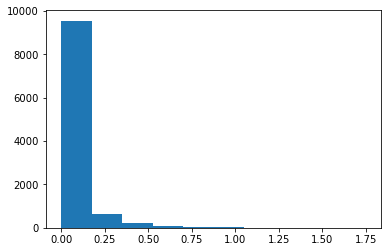

In [58]:
plt.hist(diff_norm.detach().numpy())

Hyperparameters a = 1.6075817713278566 and b = 0.6305517990336164


(array([  26.,   84.,  170.,  262.,  480.,  888., 1782., 3278., 2954.,
         632.]),
 array([0.30429095, 0.37386185, 0.44343275, 0.51300365, 0.58257455,
        0.6521455 , 0.7217164 , 0.7912873 , 0.8608582 , 0.9304291 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

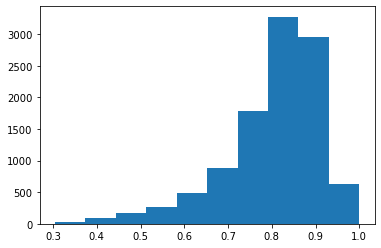

In [59]:
x = np.linspace(0, 1, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))
EPS = 1e-4
val_indices = row != col

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

q =  torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
plt.hist(q.detach().numpy())

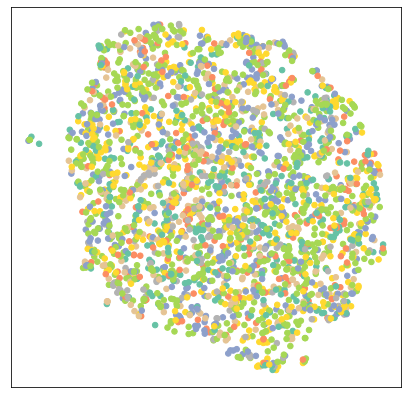

In [327]:
from umap import UMAP
def visualize_umap(out, color, size=30, epoch=None, loss = None):
    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    z = umap_2d.fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()
visualize_umap(out, data.y.numpy(), size=30, epoch=None, loss = None)

In [334]:
def edge_prediction(embeds, out_dim, train_data, test_data, val_data,
                    lr=0.01, wd=1e-4,
                    patience = 30, max_epochs=3000, print_int=False):
    logreg = LogReg(embeds.shape[1], out_dim)
    opt = torch.optim.Adam(logreg.parameters(), lr=lr, weight_decay=wd)
    output_activation = torch.nn.Sigmoid()
    last_roc = 0
    trigger_times = 0
    best_val_roc = 0
    best_val_ap = 0
    add_neg_samples = True
    loss_fn = torch.nn.BCELoss()
    results = []
    best_epoch  = 0
    pos_edge_index = train_data.pos_edge_label_index
    neg_edge_index = train_data.neg_edge_label_index
    for epoch in range(max_epochs):
        logreg.train()
        opt.zero_grad()

        #### 1st alternative:
        logits_temp = logreg(embeds)
        logits = output_activation(torch.mm(logits_temp, logits_temp.t()))
        loss = (loss_fn(logits[pos_edge_index[0,:],pos_edge_index[1,:]], torch.ones(pos_edge_index.shape[1]))+
                    loss_fn(logits[neg_edge_index[0,:],neg_edge_index[1,:]], torch.zeros(neg_edge_index.shape[1])))
        loss.backward(retain_graph=True)
        opt.step()

        logreg.eval()
        with torch.no_grad():
            try:
                val_roc, val_ap = get_scores(val_data.pos_edge_label_index, val_data.neg_edge_label_index, logits)
            except:
                val_roc, val_ap  = np.nan, np.nan
            try:
                test_roc, test_ap = get_scores(test_data.pos_edge_label_index, test_data.neg_edge_label_index, logits)
            except:
                test_roc, test_ap = np.nan, np.nan
            try:
                train_roc, train_ap = get_scores(train_data.pos_edge_label_index, train_data.neg_edge_label_index, logits)
            except:
                train_roc, train_ap = np.nan, np.nan

            if np.isnan(val_roc):
                break
            if (np.isnan(val_roc) ==False) & (val_roc >= best_val_roc):
                best_val_roc = val_roc

            current_roc = val_roc
            results += [[epoch, val_ap, val_roc, test_ap, test_roc, train_ap, train_roc ]]
            if print_int:
                print([epoch, val_ap, val_roc, test_ap, test_roc, train_ap, train_roc ])
            if current_roc <= last_roc:
                trigger_times += 1
                #print('Trigger Times:', trigger_times)
                if trigger_times >= patience:
                    print('Early stopping!\nStart to test process.')
                    break
            else:
                #print('trigger times: 0')
                trigger_times = 0
                last_roc= current_roc
                best_epoch = epoch
    return(logreg, results, best_epoch)

Hyperparameters a = 2 and b = 0.5
Epoch=000, loss=7.3032
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.78374541458943, 0.7686872185747369, 0.7618307774845262, 0.7530607018518991, 0.5428571701049805, 0.21953578293323517, 0.5285714268684387, 0.21808511018753052, 0]


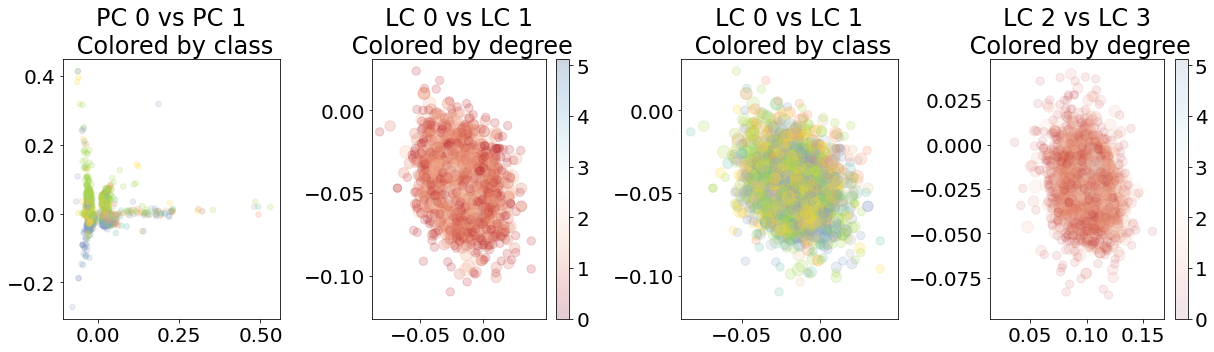

Epoch=001, loss=6.0899
Epoch=002, loss=5.7075
Epoch=003, loss=5.4875
Epoch=004, loss=5.2800
Epoch=005, loss=5.0798
Epoch=006, loss=4.8721
Epoch=007, loss=4.6496
Epoch=008, loss=4.4339
Epoch=009, loss=4.2169
Epoch=010, loss=3.9848
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9092725928282511, 0.9056750134204562, 0.9088589956396342, 0.8991258558877537, 0.7857142686843872, 0.5430367588996887, 0.6785714030265808, 0.5174081325531006, 10]


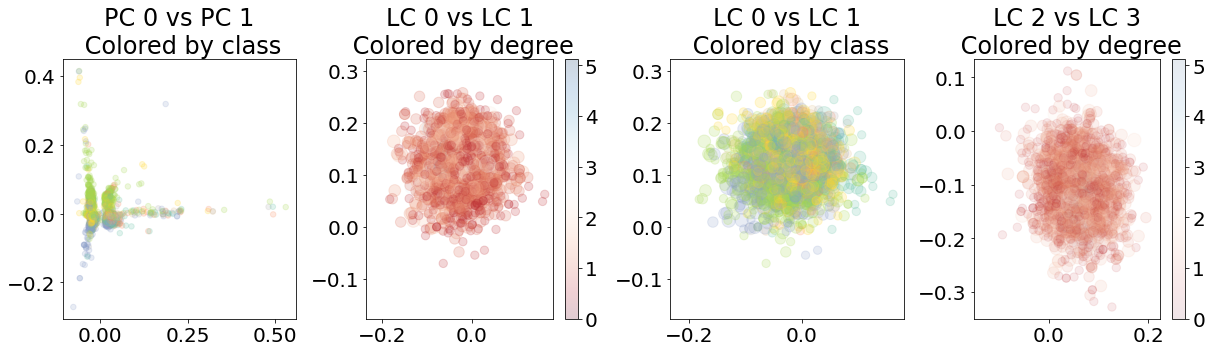

Epoch=011, loss=3.7962
Epoch=012, loss=3.6178
Epoch=013, loss=3.5017
Epoch=014, loss=3.4352
Epoch=015, loss=3.3950
Epoch=016, loss=3.3714
Epoch=017, loss=3.3581
Epoch=018, loss=3.3492
Epoch=019, loss=3.3407
Epoch=020, loss=3.3366
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9340466933410863, 0.9221857255760931, 0.9472219321712894, 0.9309301825595909, 0.8285714387893677, 0.6552224159240723, 0.7714285850524902, 0.6179884076118469, 20]


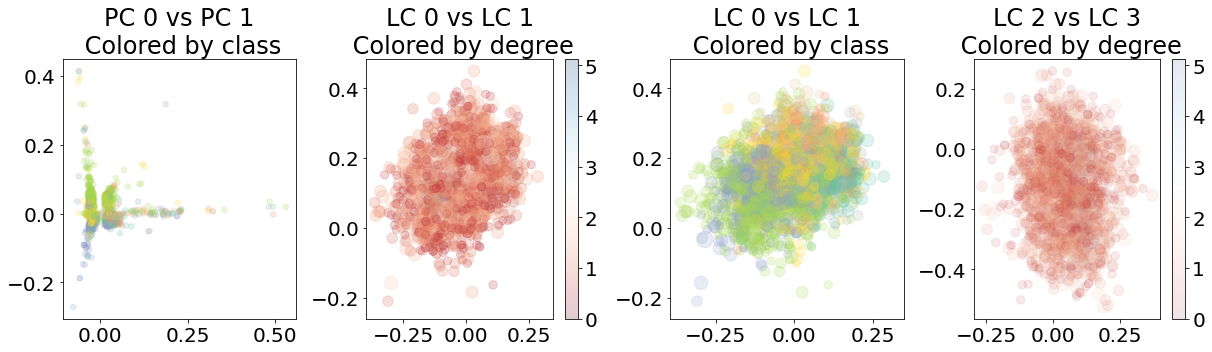

Epoch=021, loss=3.3328
Epoch=022, loss=3.3310
Epoch=023, loss=3.3283
Epoch=024, loss=3.3258
Epoch=025, loss=3.3241
Epoch=026, loss=3.3234
Epoch=027, loss=3.3230
Epoch=028, loss=3.3213
Epoch=029, loss=3.3213
Epoch=030, loss=3.3200
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.97472004469832, 0.9749470579444997, 0.9677203316902447, 0.9649720929003645, 0.8571428656578064, 0.667311429977417, 0.8142856955528259, 0.664893627166748, 30]


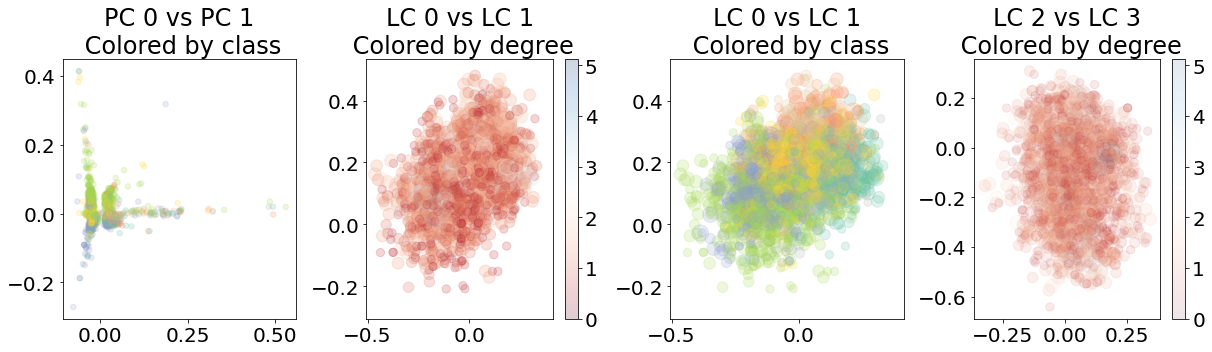

Epoch=031, loss=3.3197
Epoch=032, loss=3.3198
Epoch=033, loss=3.3189
Epoch=034, loss=3.3181
Epoch=035, loss=3.3184
Epoch=036, loss=3.3172
Epoch=037, loss=3.3165
Epoch=038, loss=3.3161
Epoch=039, loss=3.3153
Epoch=040, loss=3.3157
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9769454036273398, 0.9767580311351178, 0.9711301304509071, 0.9701087103528514, 0.7928571701049805, 0.6919729113578796, 0.7142857313156128, 0.6175048351287842, 40]


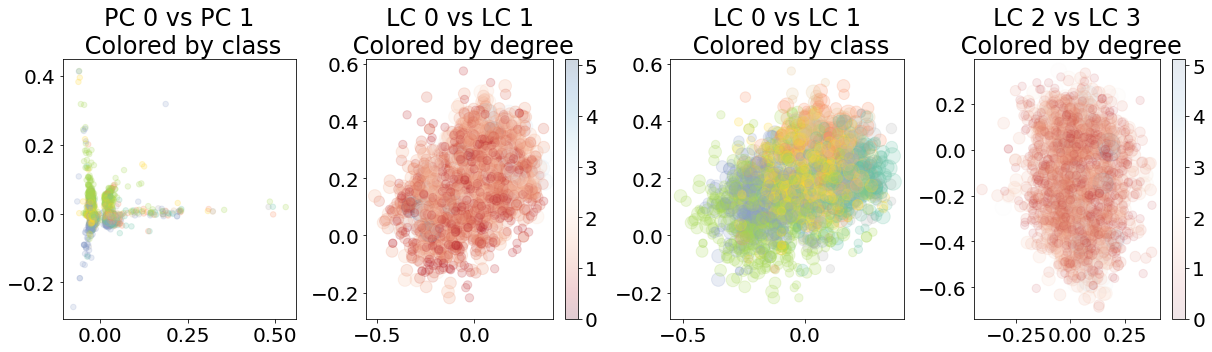

Epoch=041, loss=3.3155
Epoch=042, loss=3.3152
Epoch=043, loss=3.3147
Epoch=044, loss=3.3140
Epoch=045, loss=3.3139
Epoch=046, loss=3.3140
Epoch=047, loss=3.3133
Epoch=048, loss=3.3132
Epoch=049, loss=3.3125
Epoch=050, loss=3.3122
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9738678762300579, 0.9721532838380962, 0.9703451926158233, 0.9702534900970174, 0.8571428656578064, 0.6905222535133362, 0.7714285850524902, 0.6431334614753723, 50]


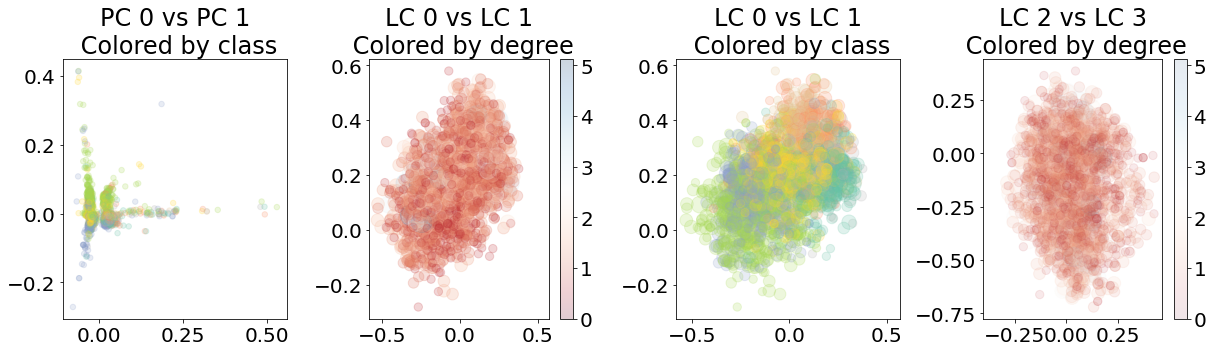

Epoch=051, loss=3.3121
Epoch=052, loss=3.3121
Epoch=053, loss=3.3113
Epoch=054, loss=3.3110
Epoch=055, loss=3.3114
Epoch=056, loss=3.3108
Epoch=057, loss=3.3107
Epoch=058, loss=3.3101
Epoch=059, loss=3.3101
Epoch=060, loss=3.3097
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9749940224834059, 0.9749263992935372, 0.9700031325500756, 0.9705542255684959, 0.8142856955528259, 0.6721469759941101, 0.7928571701049805, 0.6257253289222717, 60]


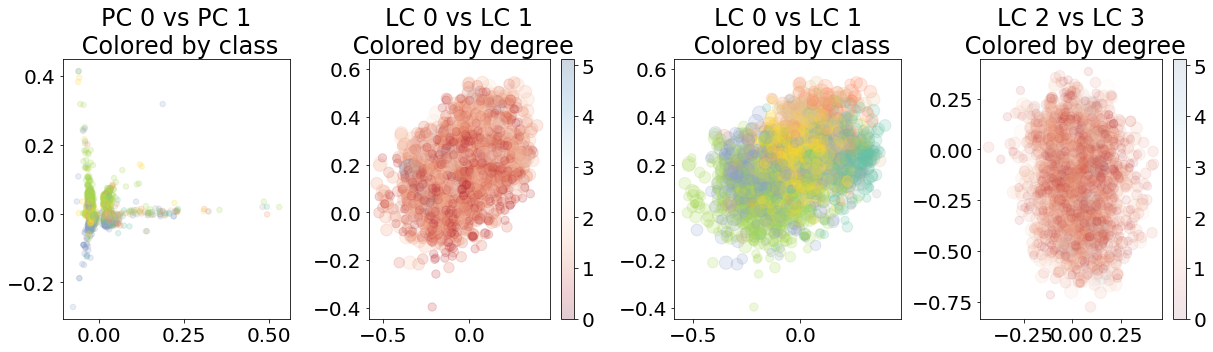

Epoch=061, loss=3.3102
Epoch=062, loss=3.3100
Epoch=063, loss=3.3098
Epoch=064, loss=3.3095
Epoch=065, loss=3.3095
Epoch=066, loss=3.3092
Epoch=067, loss=3.3089
Epoch=068, loss=3.3091
Epoch=069, loss=3.3090
Epoch=070, loss=3.3086
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9797811494148787, 0.9803687051648822, 0.9675330988121515, 0.9645877390481441, 0.8500000238418579, 0.6702127456665039, 0.7214285731315613, 0.6363636255264282, 70]


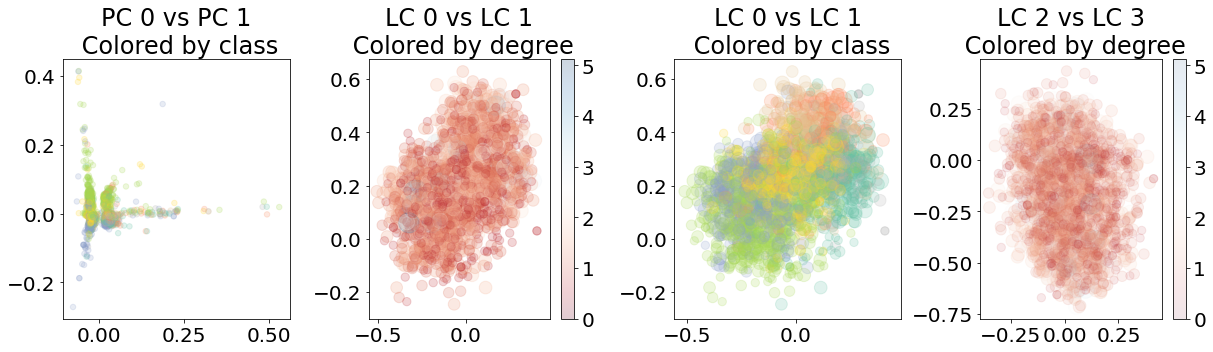

Epoch=071, loss=3.3087
Epoch=072, loss=3.3084
Epoch=073, loss=3.3079
Epoch=074, loss=3.3078
Epoch=075, loss=3.3077
Epoch=076, loss=3.3079
Epoch=077, loss=3.3077
Epoch=078, loss=3.3080
Epoch=079, loss=3.3072
Epoch=080, loss=3.3074
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9748704755561276, 0.9744584164422598, 0.9674682874312729, 0.965062823140193, 0.7785714268684387, 0.664893627166748, 0.7785714268684387, 0.6823017597198486, 80]


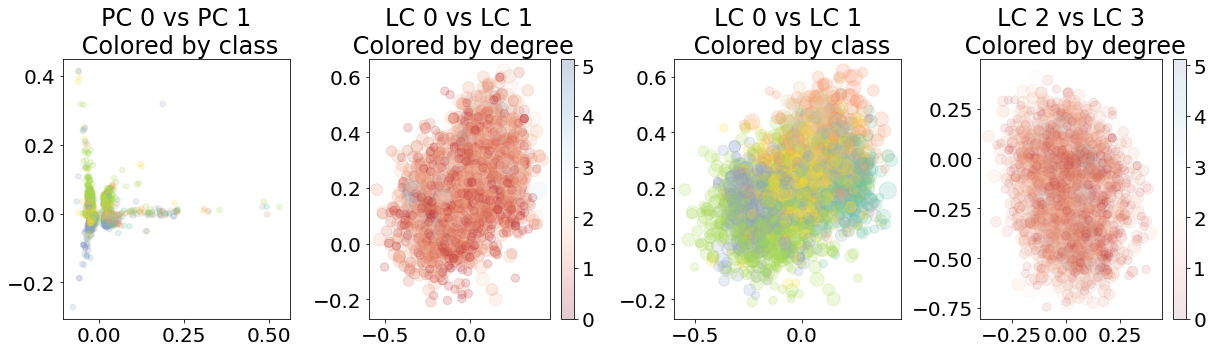

Epoch=081, loss=3.3075
Epoch=082, loss=3.3078
Epoch=083, loss=3.3073
Epoch=084, loss=3.3073
Epoch=085, loss=3.3074
Epoch=086, loss=3.3069
Epoch=087, loss=3.3070
Epoch=088, loss=3.3063
Epoch=089, loss=3.3068
Epoch=090, loss=3.3061
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9729259705421628, 0.9728275346572169, 0.9646831983696337, 0.9658062241168905, 0.8642857074737549, 0.6847195625305176, 0.7071428298950195, 0.5870406031608582, 90]


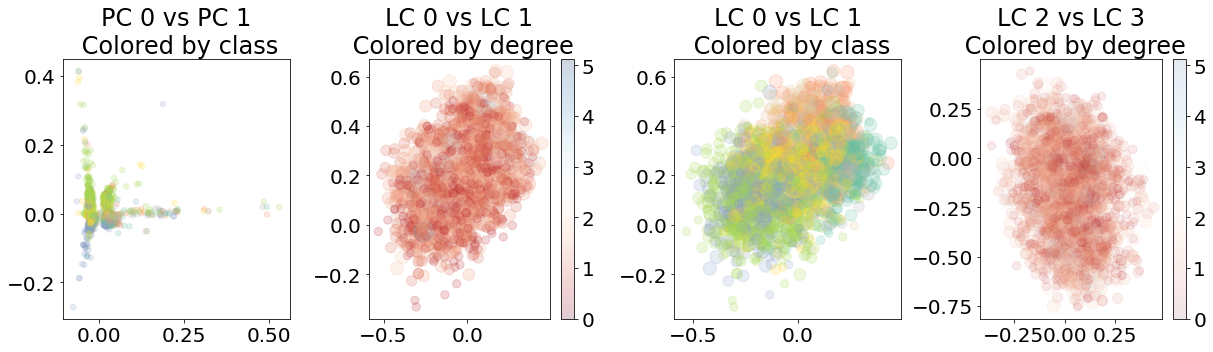

Epoch=091, loss=3.3063
Epoch=092, loss=3.3061
Epoch=093, loss=3.3060
Epoch=094, loss=3.3057
Epoch=095, loss=3.3059
Epoch=096, loss=3.3058
Epoch=097, loss=3.3056
Epoch=098, loss=3.3058
Epoch=099, loss=3.3058
Epoch=100, loss=3.3053
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9757645958642737, 0.9762145899749667, 0.9665789312603293, 0.9675469795607119, 0.7857142686843872, 0.664893627166748, 0.75, 0.6373307704925537, 100]


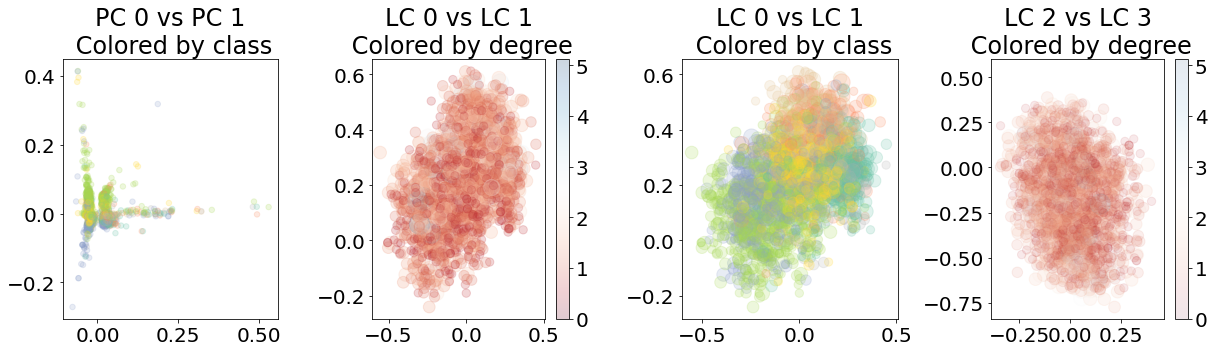

Epoch=101, loss=3.3052
Epoch=102, loss=3.3055
Epoch=103, loss=3.3054
Epoch=104, loss=3.3052
Epoch=105, loss=3.3046
Epoch=106, loss=3.3050
Epoch=107, loss=3.3048
Epoch=108, loss=3.3048
Epoch=109, loss=3.3047
Epoch=110, loss=3.3045
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9775142109995837, 0.9776199534348566, 0.968548477112581, 0.969030503887293, 0.7928571701049805, 0.6764990091323853, 0.7785714268684387, 0.6755319237709045, 110]


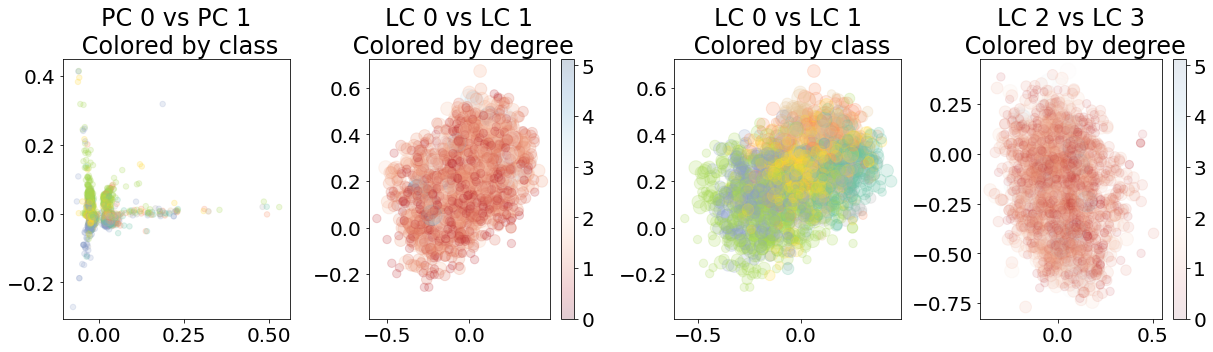

Epoch=111, loss=3.3043
Epoch=112, loss=3.3045
Epoch=113, loss=3.3045
Epoch=114, loss=3.3043
Epoch=115, loss=3.3041
Epoch=116, loss=3.3042
Epoch=117, loss=3.3039
Epoch=118, loss=3.3041
Epoch=119, loss=3.3040
Epoch=120, loss=3.3039
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9758693513461131, 0.9750527495030464, 0.9691641852309265, 0.967641898394688, 0.8142856955528259, 0.6682785153388977, 0.7928571701049805, 0.664893627166748, 120]


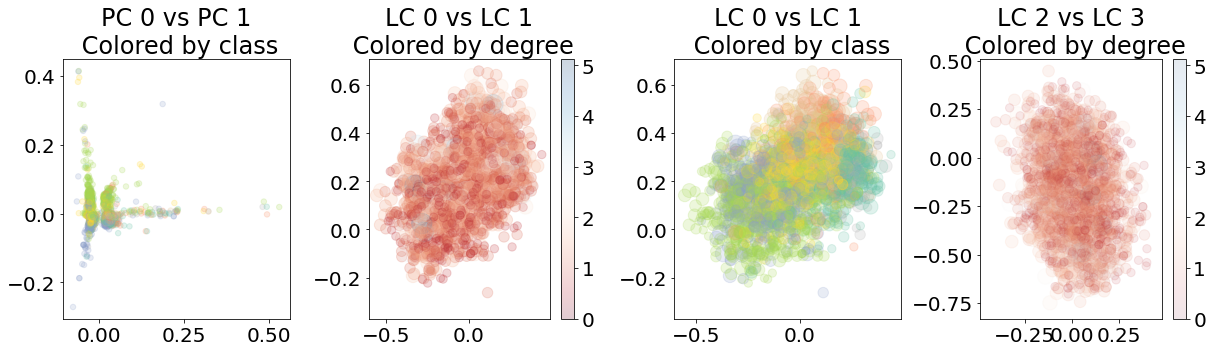

Epoch=121, loss=3.3033
Epoch=122, loss=3.3033
Epoch=123, loss=3.3035
Epoch=124, loss=3.3037
Epoch=125, loss=3.3031
Epoch=126, loss=3.3035
Epoch=127, loss=3.3035
Epoch=128, loss=3.3031
Epoch=129, loss=3.3028
Epoch=130, loss=3.3032
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9750828412308044, 0.9741991097228643, 0.9607927152007893, 0.9595732138438604, 0.8071428537368774, 0.6513539552688599, 0.6928571462631226, 0.6054158806800842, 130]


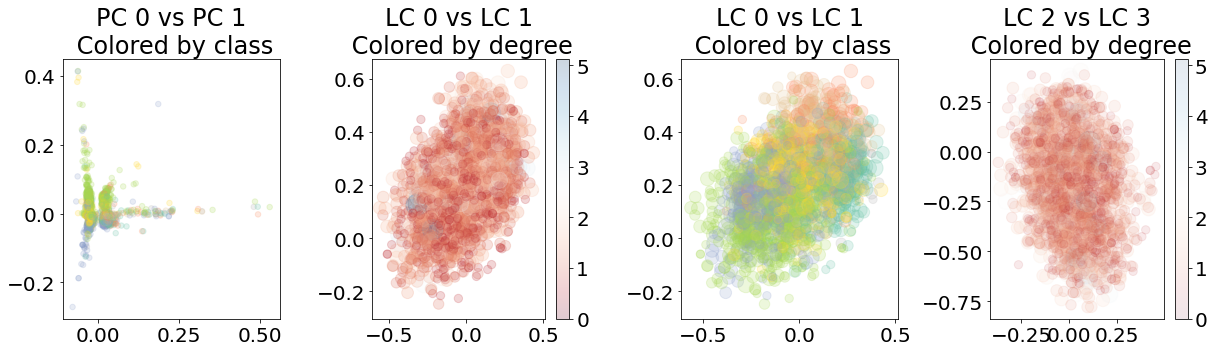

Epoch=131, loss=3.3031
Epoch=132, loss=3.3028
Epoch=133, loss=3.3029
Epoch=134, loss=3.3029
Epoch=135, loss=3.3025
Epoch=136, loss=3.3028
Epoch=137, loss=3.3025
Epoch=138, loss=3.3027
Epoch=139, loss=3.3026
Epoch=140, loss=3.3025
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9816739965715665, 0.9814468255162293, 0.9714109797680472, 0.9711141406087003, 0.8071428537368774, 0.6663442850112915, 0.7571428418159485, 0.6184719800949097, 140]


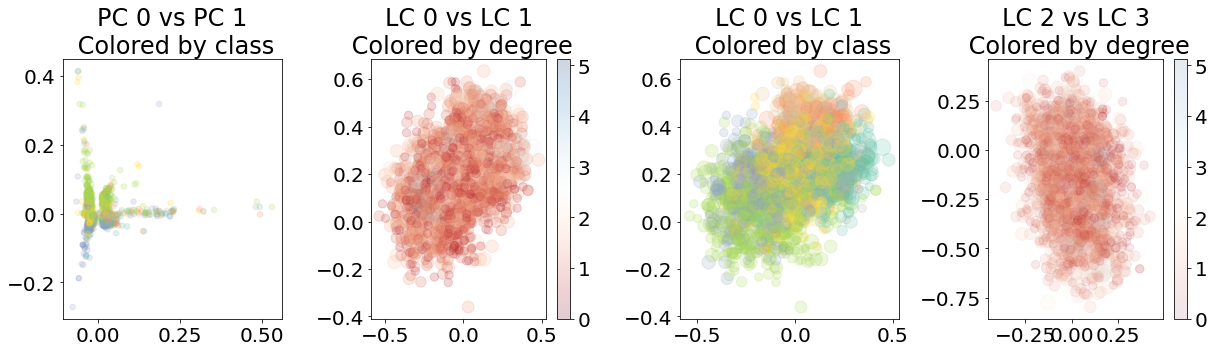

Epoch=141, loss=3.3024
Epoch=142, loss=3.3025
Epoch=143, loss=3.3022
Epoch=144, loss=3.3022
Epoch=145, loss=3.3020
Epoch=146, loss=3.3017
Epoch=147, loss=3.3025
Epoch=148, loss=3.3021
Epoch=149, loss=3.3019
Epoch=150, loss=3.3020
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9731234917196501, 0.97318657465472, 0.9665177205117219, 0.9646517901747262, 0.8357142806053162, 0.6590909361839294, 0.75, 0.6349129676818848, 150]


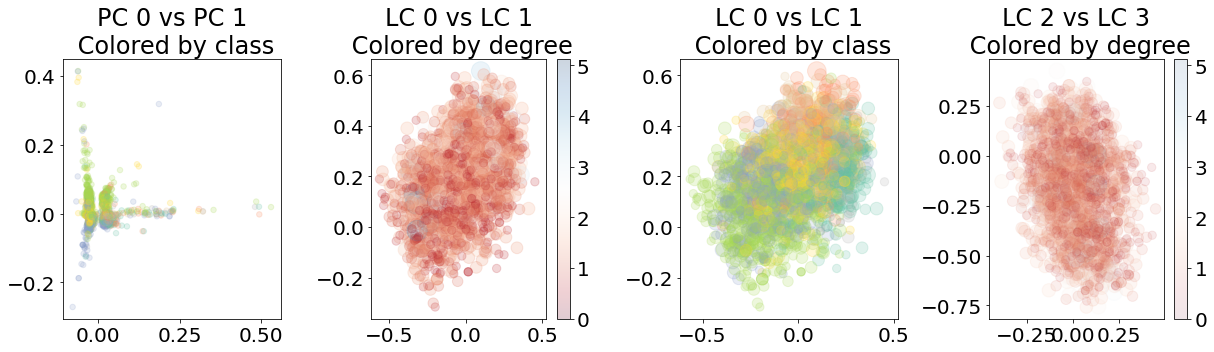

Epoch=151, loss=3.3020
Epoch=152, loss=3.3013
Epoch=153, loss=3.3014
Epoch=154, loss=3.3014
Epoch=155, loss=3.3014
Epoch=156, loss=3.3013
Epoch=157, loss=3.3014
Epoch=158, loss=3.3011
Epoch=159, loss=3.3013
Epoch=160, loss=3.3012
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.973730577042841, 0.9738650370048952, 0.9668597805774694, 0.9634394609303294, 0.8285714387893677, 0.6508703827857971, 0.8071428537368774, 0.6431334614753723, 160]


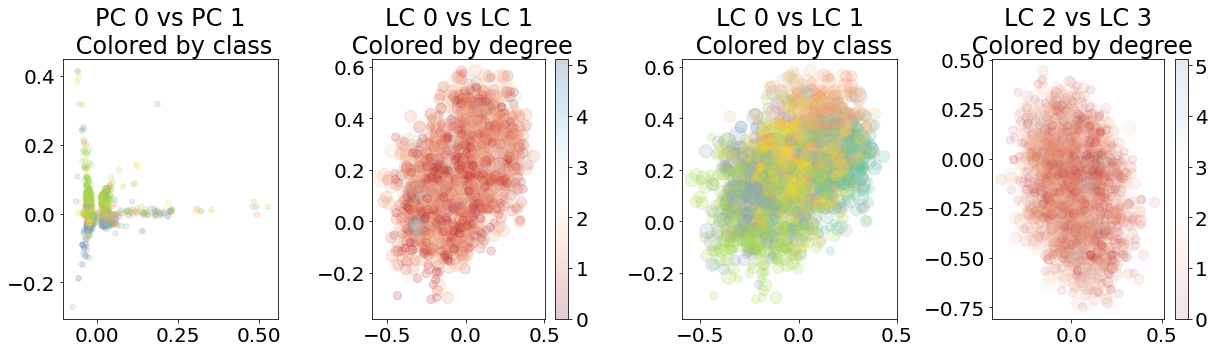

Epoch=161, loss=3.3011
Epoch=162, loss=3.3010
Epoch=163, loss=3.3013
Epoch=164, loss=3.3009
Epoch=165, loss=3.3009
Epoch=166, loss=3.3009
Epoch=167, loss=3.3011
Epoch=168, loss=3.3010
Epoch=169, loss=3.3009
Epoch=170, loss=3.3009
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9750312081971015, 0.9750407764488367, 0.9702011673249822, 0.9716744209412034, 0.8500000238418579, 0.6532881855964661, 0.8285714387893677, 0.6489361524581909, 170]


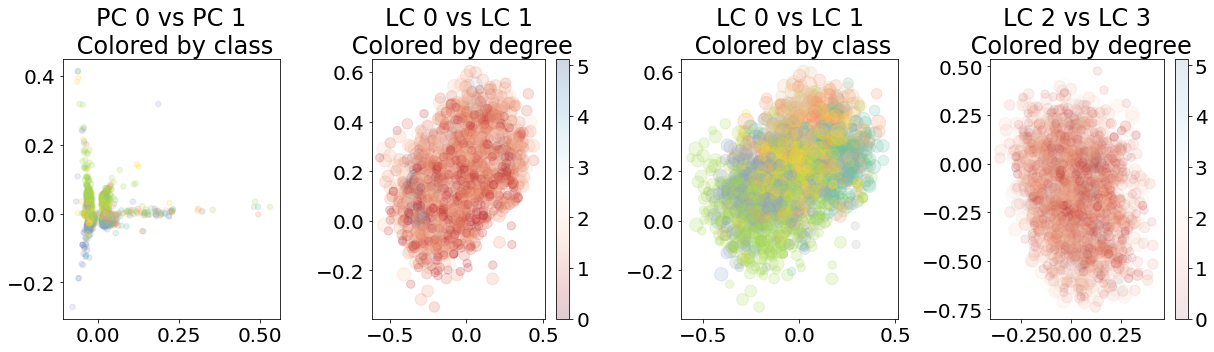

Epoch=171, loss=3.3005
Epoch=172, loss=3.3006
Epoch=173, loss=3.3005
Epoch=174, loss=3.3004
Epoch=175, loss=3.3005
Epoch=176, loss=3.3003
Epoch=177, loss=3.3001
Epoch=178, loss=3.3002
Epoch=179, loss=3.3004
Epoch=180, loss=3.3001
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9752751991049216, 0.9749284375476809, 0.9729880567027569, 0.9730585946803655, 0.800000011920929, 0.6358800530433655, 0.7928571701049805, 0.6262089014053345, 180]


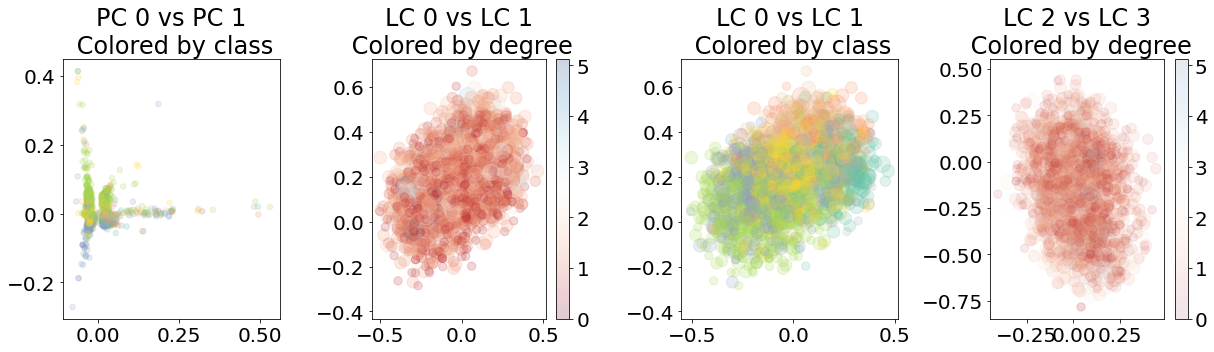

Epoch=181, loss=3.3002
Epoch=182, loss=3.3000
Epoch=183, loss=3.3001
Epoch=184, loss=3.3000
Epoch=185, loss=3.3000
Epoch=186, loss=3.3000
Epoch=187, loss=3.3001
Epoch=188, loss=3.2999
Epoch=189, loss=3.2998
Epoch=190, loss=3.3000
=== Evaluation ===
Early stopping!
Start to test process.
Early stopping!
Start to test process.
Early stopping!
Start to test process.
['ICA', 0.9753943770831945, 0.9747334488425112, 0.9718718606987387, 0.9700680755993579, 0.7785714268684387, 0.6523211002349854, 0.6785714030265808, 0.5957446694374084, 190]


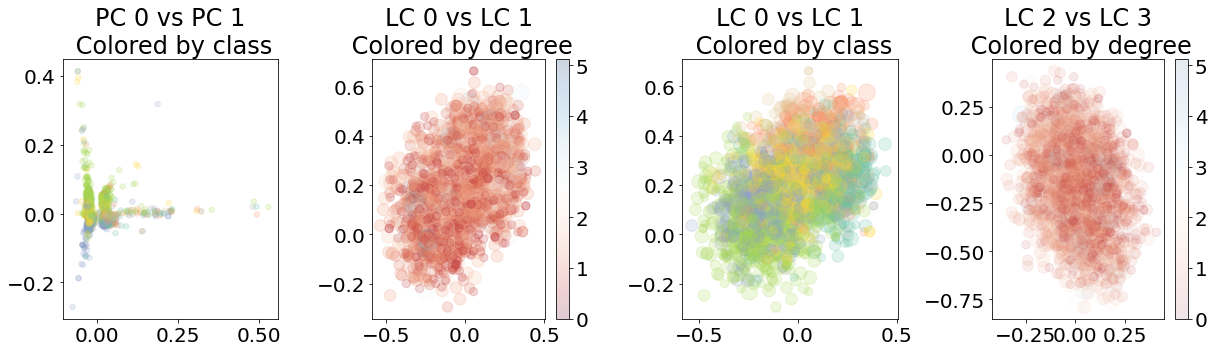

Epoch=191, loss=3.2996
Epoch=192, loss=3.3001
Epoch=193, loss=3.2996
Epoch=194, loss=3.2998
Epoch=195, loss=3.2995
Epoch=196, loss=3.2995
Epoch=197, loss=3.2995
Epoch=198, loss=3.2996
Epoch=199, loss=3.2995


In [122]:
model = GCN(data.num_features, 128, 128, n_layers=2,
                                normalize=True)
def deg(index, num_nodes = None,           
        dtype = None):
    r"""Computes the (unweighted) degree of a given one-dimensional index tensor.
    Args:
    index (LongTensor): Index tensor.
    num_nodes (int, optional): The number of nodes, *i.e.*
    :obj:`max_val + 1` of :attr:`index`. (default: :obj:`None`)
    dtype (:obj:`torch.dtype`, optional): The desired data type of the
    returned tensor.\n\n    :rtype: :class:`Tensor`\n    """
    if index.shape[0] != 1: # modify input 
        index = index[0] 
    N = num_nodes
    out = torch.zeros((N, ), dtype=dtype, device=index.device)
    one = torch.ones((index.size(0), ), dtype=out.dtype, device=out.device)
    return out.scatter_add_(0, index, one)
### we might not want to normalize.
### we might not want to use the dot product as a similarity matrix/
optimizer = torch.optim.Adam(model.parameters(), lr=0.005,
                                 weight_decay=1e-4)
criterion = torch.nn.BCELoss()
from models.baseline_models import LogReg
from sklearn.metrics import accuracy_score
from train_utils import *
from scipy import optimize

training_rate = 0.85
MAX_EPOCH_EVAL = 100
val_ratio = (1.0 - training_rate) / 3
test_ratio = (1.0 - training_rate) / 3 * 2
transform = RandomLinkSplit(num_val=val_ratio, num_test=test_ratio,
                                is_undirected=True, split_labels=True)
transform_nodes = RandomNodeSplit(split = 'test_rest',
                                      num_train_per_class = 20,
                                      num_val = 500)
train_data, val_data, test_data = transform(data)
rand_data = transform_nodes(data)
MIN_DIST = 1e-2

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))
EPS = 1e-5
val_indices = row != col

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
a = 2#p[0]
b = 0.5#p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))



for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    #edge
    #print("out", out)
    # pdb.set_trace()
    #### Evaluate on existing edges
    output_activation = torch.nn.Sigmoid()
    #logits = output_activation(torch.mm(logits_temp, logits_temp.t()))
    #edge = output_activation(torch.mm(logits_temp, logits_temp.t()))
    #### Look for min per node
    #min_dist = 
    ##### Subsample training edges
    #train_index = torch.randperm(data.edge_index.shape[1])[:5000]
    train_index = np.arange(data.edge_index.shape[1]) #dattorch.randperm(data.edge_index.shape[1])#[:1000]
    #train_indices = train_index[row[train_index]!=col[train_index]]
    (row_pos, col_pos), edge_weights_pos = remove_self_loops(edge_index, edge_weights)
    #d = torch.cdist(out[row[train_index]], out[col[train_index]], p=2.0)
    #d_min = torch.sort(d, 1)[0][:,1]
    diff_norm = torch.sum(torch.square(out[row_pos] - out[col_pos]), 1)
    ### translate/shrink
    diff_norm = torch.clamp(diff_norm, EPS, 1.-EPS)  ### ensure above 0
#     p , _ = optimize.curve_fit(dist_low_dim, x, f(x, torch.min(torch.square(diff_norm )).item()))
#     a = p[0]
#     b = p[1] 
#     #diff_norm = diff_norm - 
#     print("Hyperparameters a = " + str(a) + " and b = " + str(b))
    
    #print("diffnorm pos", torch.sum(torch.isnan(diff_norm)), torch.max(diff_norm),  torch.min(diff_norm))
    #q = torch.exp(-1.0 *torch.log(1.  + a * torch.exp(b * torch.log(diff_norm))))
    q =  torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
    #print("q_pos",torch.max(q),  torch.min(q))
    #loss = criterion(q, L[val_indices])
    #loss = torch.mean(edge_weights_pos * (torch.log(edge_weights_pos) - torch.log(q)  ))  + torch.mean((1.-edge_weights_pos) * (torch.log(1.-edge_weights_pos) - torch.log(1.-q)  )) 
    loss = torch.mean(q * (-torch.log(edge_weights_pos) + torch.log(q)  ))  + torch.mean((1.-q) * (-torch.log(1.-edge_weights_pos) + torch.log(1.-q)  )) 
    #print("loss pos", loss)
    neg_edge_index = negative_sampling(data.edge_index, data.num_nodes)
    row_neg, col_neg = neg_edge_index[0], neg_edge_index[1]
#     loss += criterion(output_activation(torch.sum(out[neg_edge_index[0]] * out[neg_edge_index[1]], 1)), 
#                       torch.zeros((neg_edge_index.shape[1])))
    diff_norm = torch.sum(torch.square(out[row_neg] - out[col_neg]), 1)
    diff_norm = torch.clamp(diff_norm, EPS, 1.-EPS)  ### ensure above 0
    #print("diffnorm neg", torch.sum(torch.isnan(diff_norm)), torch.max(diff_norm),  torch.min(diff_norm))
    #q_neg = torch.exp(-1.0*torch.log(1.  + a * torch.exp(b * torch.log(diff_norm))))
    q_neg = torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
    #print("q_neg", torch.max(q_neg),  torch.min(q_neg))
    edge_weights_neg = EPS * torch.ones((neg_edge_index.shape[1], 1))
    #loss +=  torch.mean(EPS * (torch.log(edge_weights_neg) - torch.log(q_neg)  ))  + torch.mean((1.-EPS) * (torch.log(1.-edge_weights_neg) - torch.log(1.-q_neg)  )) 
    loss +=  torch.mean(q_neg * (-torch.log(edge_weights_neg) + torch.log(q_neg)  ))  + torch.mean((1.-q_neg) * (-torch.log(1.-edge_weights_neg) + torch.log(1.-q_neg)  )) 
    
    #loss += criterion(torch.hstack((q_neg.reshape([-1,1]), 1-q_neg.reshape([-1,1]))),
     #                 torch.hstack((EPS * torch.ones((neg_edge_index.shape[1], 1)), 
     #         (1.-EPS) * torch.ones((neg_edge_index.shape[1], 1)))))
    loss.backward()
    
    optimizer.step()
    #print("weight", model.fc[0].weight.grad)

    print('Epoch={:03d}, loss={:.4f}'.format(epoch, loss.item()))
    if epoch % 10 == 0 :
                print("=== Evaluation ===")
                embeds = out
                _, res, best_epoch = edge_prediction(embeds.detach(), embeds.shape[1],
                                         train_data, test_data, val_data,
                                         lr=0.01, wd=1e-4,
                                         patience = 10,
                                         max_epochs=MAX_EPOCH_EVAL)
                val_ap, val_roc, test_ap, test_roc, train_ap, train_roc = res[best_epoch][1], res[best_epoch][2], res[best_epoch][3], res[best_epoch][4], res[best_epoch][5], res[best_epoch][6]
                
                _, nodes_res, best_epoch = node_prediction(embeds.detach(),
                                               dataset.num_classes, data.y,
                                               rand_data.train_mask, rand_data.test_mask,
                                               rand_data.val_mask,
                                               lr=0.01, wd=1e-4,
                                               patience = 20,
                                               max_epochs=MAX_EPOCH_EVAL)

                acc_train, acc = nodes_res[best_epoch][2], nodes_res[best_epoch][3]

                _, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                                               dataset.num_classes, data.y,
                                               data.train_mask, data.test_mask,
                                               data.val_mask,
                                               lr=0.005, wd=1e-4,
                                               patience = 10,
                                               max_epochs=MAX_EPOCH_EVAL)
                acc_train_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3]
                print(['ICA', train_roc, train_ap,
                   test_roc, test_ap, acc_train, acc,
                   acc_train_default, acc_default, epoch,])
                h = (out).detach().cpu().numpy() 
                fig, ax = plt.subplots(1, 4, figsize=(17,5))
                hh = PCA(n_components=5).fit_transform((data.x.numpy()))

                ax[0].scatter(hh[:, 0], hh[:, 1], s=30, c=data.y, alpha=0.2, cmap="Set2")    
                ax[0].tick_params(axis='both', labelsize=20)
                ax[0].set_title('PC ' + str(0) + ' vs PC ' +str(1)  + '\n Colored by class', fontdict = {'fontsize':24})
                u = 0
                v = 1
                deg1 = deg(data.edge_index, data.num_nodes)
                hs = ax[1].scatter(h[:, u], h[:, v], s= 100 * np.log(deg(data.edge_index, data.num_nodes).numpy()), 
                            c=np.log(deg1), alpha=0.2, cmap="RdBu")
                # ax[1].legend(loc='ll', label='legend label')  # automatically infer handles and labels
                # ax[1].legend(hs, loc='t', ncols=5, frame=False)  # automatically infer labels from handles

                ax[1].tick_params(axis='both', labelsize=20)
                ax[1].set_title('LC ' + str(u) + ' vs LC ' +str(v)  + '\n Colored by degree', fontdict = {'fontsize':24})


                ax[2].scatter(h[:, u], h[:, v], s= 100 * np.log(deg1.numpy()), 
                            c=data.y.numpy(), alpha=0.2, cmap="Set2")  
                ax[2].tick_params(axis='both', labelsize=20)
                ax[2].set_title('LC ' + str(u) + ' vs LC ' +str(v) + '\n Colored by class', fontdict = {'fontsize':24})
                hs3 = ax[3].scatter(h[:, 2], h[:, 3], s= 100 * np.log(deg1.numpy()), 
                            c=np.log(deg1), alpha=0.1, cmap="RdBu") 
                ax[3].set_title('LC ' + str(2) + ' vs LC ' +str(3) + '\n Colored by degree', fontdict = {'fontsize':24})
                ax[3].tick_params(axis='both', labelsize=20)
                # ax[4].scatter(h[:, 2], h[:, 3], s= 100 * np.log(deg(data.edge_index).numpy()), 
                #             c=labels, alpha=0.2, cmap="Set2")  
                # ax[4].tick_params(axis='both', labelsize=20)
                # ax[4].set_title('LC ' + str(2) + ' vs LC ' +str(3) + '\n Colored by class', fontdict = {'fontsize':24})
                cbar = fig.colorbar(hs, ax=ax[1])
                cbar.ax.tick_params(labelsize=20) 
                cbar2 =fig.colorbar(hs3, ax=ax[3])
                cbar2.ax.tick_params(labelsize=20) 
                #fig.suptitle('Accuracy in classification task: %.2f'%test_acc_list[-1],  fontsize=20)
                plt.tight_layout();
                plt.show()


None;

In [105]:
deg(data.edge_index, data.num_nodes)

TypeError: 'Tensor' object is not callable

In [62]:
from sklearn.decomposition import PCA
def deg(index, num_nodes = None,           
        dtype = None):
    r"""Computes the (unweighted) degree of a given one-dimensional index tensor.
    Args:
    index (LongTensor): Index tensor.
    num_nodes (int, optional): The number of nodes, *i.e.*
    :obj:`max_val + 1` of :attr:`index`. (default: :obj:`None`)
    dtype (:obj:`torch.dtype`, optional): The desired data type of the
    returned tensor.\n\n    :rtype: :class:`Tensor`\n    """
    if index.shape[0] != 1: # modify input 
        index = index[0] 
    N = num_nodes
    out = torch.zeros((N, ), dtype=dtype, device=index.device)
    one = torch.ones((index.size(0), ), dtype=out.dtype, device=out.device)
    return out.scatter_add_(0, index, one)


h = (out).detach().cpu().numpy() 
fig, ax = plt.subplots(1, 4, figsize=(17,5))
hh = PCA(n_components=5).fit_transform((data.x.numpy()))

ax[0].scatter(hh[:, 0], hh[:, 1], s=30, c=data.y, alpha=0.2, cmap="Set2")    
ax[0].tick_params(axis='both', labelsize=20)
ax[0].set_title('PC ' + str(0) + ' vs PC ' +str(1)  + '\n Colored by class', fontdict = {'fontsize':24})
u = 0
v = 1
deg1 = deg(data.edge_index, data.num_nodes)
hs = ax[1].scatter(h[:, u], h[:, v], s= 100 * np.log(deg(data.edge_index, data.num_nodes).numpy()), 
            c=np.log(deg1), alpha=0.2, cmap="RdBu")
# ax[1].legend(loc='ll', label='legend label')  # automatically infer handles and labels
# ax[1].legend(hs, loc='t', ncols=5, frame=False)  # automatically infer labels from handles

ax[1].tick_params(axis='both', labelsize=20)
ax[1].set_title('LC ' + str(u) + ' vs LC ' +str(v)  + '\n Colored by degree', fontdict = {'fontsize':24})


ax[2].scatter(h[:, u], h[:, v], s= 100 * np.log(deg1.numpy()), 
            c=data.y.numpy(), alpha=0.2, cmap="Set2")  
ax[2].tick_params(axis='both', labelsize=20)
ax[2].set_title('LC ' + str(u) + ' vs LC ' +str(v) + '\n Colored by class', fontdict = {'fontsize':24})
hs3 = ax[3].scatter(h[:, 2], h[:, 3], s= 100 * np.log(deg1.numpy()), 
            c=np.log(deg1), alpha=0.1, cmap="RdBu") 
ax[3].set_title('LC ' + str(2) + ' vs LC ' +str(3) + '\n Colored by degree', fontdict = {'fontsize':24})
ax[3].tick_params(axis='both', labelsize=20)
# ax[4].scatter(h[:, 2], h[:, 3], s= 100 * np.log(deg(data.edge_index).numpy()), 
#             c=labels, alpha=0.2, cmap="Set2")  
# ax[4].tick_params(axis='both', labelsize=20)
# ax[4].set_title('LC ' + str(2) + ' vs LC ' +str(3) + '\n Colored by class', fontdict = {'fontsize':24})
cbar = fig.colorbar(hs, ax=ax[1])
cbar.ax.tick_params(labelsize=20) 
cbar2 =fig.colorbar(hs3, ax=ax[3])
cbar2.ax.tick_params(labelsize=20) 
#fig.suptitle('Accuracy in classification task: %.2f'%test_acc_list[-1],  fontsize=20)
plt.tight_layout();
plt.show()

In [106]:
def deg(index, num_nodes = None,           
        dtype = None):
    r"""Computes the (unweighted) degree of a given one-dimensional index tensor.
    Args:
    index (LongTensor): Index tensor.
    num_nodes (int, optional): The number of nodes, *i.e.*
    :obj:`max_val + 1` of :attr:`index`. (default: :obj:`None`)
    dtype (:obj:`torch.dtype`, optional): The desired data type of the
    returned tensor.\n\n    :rtype: :class:`Tensor`\n    """
    if index.shape[0] != 1: # modify input 
        index = index[0] 
    N = num_nodes
    out = torch.zeros((N, ), dtype=dtype, device=index.device)
    one = torch.ones((index.size(0), ), dtype=out.dtype, device=out.device)
    return out.scatter_add_(0, index, one)

Text(0.5, 1.0, 'PC 0 vs PC 1\n Colored by class')

Text(0.5, 1.0, 'LC 0 vs LC 1\n Colored by degree')

Text(0.5, 1.0, 'LC 0 vs LC 1\n Colored by class')

Text(0.5, 1.0, 'LC 2 vs LC 3\n Colored by degree')

NameError: name 'test_acc_list' is not defined

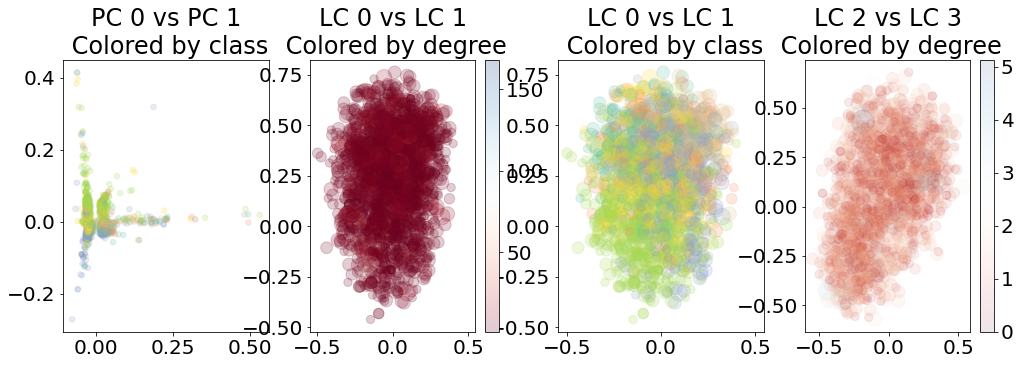

In [71]:
h = (out).detach().cpu().numpy() 
fig, ax = plt.subplots(1, 4, figsize=(17,5))
hh = PCA(n_components=5).fit_transform((data.x.numpy()))

ax[0].scatter(hh[:, 0], hh[:, 1], s=30, c=data.y, alpha=0.2, cmap="Set2")    
ax[0].tick_params(axis='both', labelsize=20)
ax[0].set_title('PC ' + str(0) + ' vs PC ' +str(1)  + '\n Colored by class', fontdict = {'fontsize':24})
u = 0
v = 1
deg1 = deg(data.edge_index, data.num_nodes)
hs = ax[1].scatter(h[:, u], h[:, v], s= 100 * np.log(deg(data.edge_index, data.num_nodes).numpy()), 
            c=(deg1), alpha=0.2, cmap="RdBu")
# ax[1].legend(loc='ll', label='legend label')  # automatically infer handles and labels
# ax[1].legend(hs, loc='t', ncols=5, frame=False)  # automatically infer labels from handles

ax[1].tick_params(axis='both', labelsize=20)
ax[1].set_title('LC ' + str(u) + ' vs LC ' +str(v)  + '\n Colored by degree', fontdict = {'fontsize':24})


ax[2].scatter(h[:, u], h[:, v], s= 100 * np.log(deg1.numpy()), 
            c=data.y.numpy(), alpha=0.2, cmap="Set2")  
ax[2].tick_params(axis='both', labelsize=20)
ax[2].set_title('LC ' + str(u) + ' vs LC ' +str(v) + '\n Colored by class', fontdict = {'fontsize':24})
hs3 = ax[3].scatter(h[:, 2], h[:, 3], s= 100 * np.log(deg1.numpy()), 
            c=np.log(deg1), alpha=0.1, cmap="RdBu") 
ax[3].set_title('LC ' + str(2) + ' vs LC ' +str(3) + '\n Colored by degree', fontdict = {'fontsize':24})
ax[3].tick_params(axis='both', labelsize=20)
# ax[4].scatter(h[:, 2], h[:, 3], s= 100 * np.log(deg(data.edge_index).numpy()), 
#             c=labels, alpha=0.2, cmap="Set2")  
# ax[4].tick_params(axis='both', labelsize=20)
# ax[4].set_title('LC ' + str(2) + ' vs LC ' +str(3) + '\n Colored by class', fontdict = {'fontsize':24})
cbar = fig.colorbar(hs, ax=ax[1])
cbar.ax.tick_params(labelsize=20) 
cbar2 =fig.colorbar(hs3, ax=ax[3])
cbar2.ax.tick_params(labelsize=20) 
fig.suptitle('Accuracy in classification task: %.2f'%test_acc_list[-1],  fontsize=20)
plt.tight_layout()

In [69]:
deg1.max()

tensor(168.)

In [33]:
def edge_prediction(embeds, out_dim, train_data, test_data, val_data,
                    lr=0.01, wd=1e-4,
                    patience = 30, max_epochs=3000, print_int=False, normalize=False):
    logreg = LogReg(embeds.shape[1], out_dim)
    opt = torch.optim.Adam(logreg.parameters(), lr=lr, weight_decay=wd)
    output_activation = torch.nn.Sigmoid()
    last_roc = 0
    trigger_times = 0
    best_val_roc = 0
    best_val_ap = 0
    add_neg_samples = True
    loss_fn = torch.nn.BCELoss()
    results = []
    best_epoch  = 0
    pos_edge_index = train_data.pos_edge_label_index
    neg_edge_index = train_data.neg_edge_label_index
    if normalize:
        embeds = F.normalize(embeds, p=2, dim=1)
    for epoch in range(max_epochs):
        logreg.train()
        opt.zero_grad()

        #### 1st alternative:
        logits_temp = logreg(embeds)
        logits = output_activation(torch.mm(logits_temp, logits_temp.t()))
        loss = (loss_fn(logits[pos_edge_index[0,:],pos_edge_index[1,:]], torch.ones(pos_edge_index.shape[1]))+
                    loss_fn(logits[neg_edge_index[0,:],neg_edge_index[1,:]], torch.zeros(neg_edge_index.shape[1])))
        loss.backward(retain_graph=True)
        opt.step()

        logreg.eval()
        with torch.no_grad():
            try:
                val_roc, val_ap = get_scores(val_data.pos_edge_label_index, val_data.neg_edge_label_index, logits)
            except:
                val_roc, val_ap  = np.nan, np.nan
            try:
                test_roc, test_ap = get_scores(test_data.pos_edge_label_index, test_data.neg_edge_label_index, logits)
            except:
                test_roc, test_ap = np.nan, np.nan
            try:
                train_roc, train_ap = get_scores(train_data.pos_edge_label_index, train_data.neg_edge_label_index, logits)
            except:
                train_roc, train_ap = np.nan, np.nan

            if np.isnan(val_roc):
                break
            if (np.isnan(val_roc) ==False) & (val_roc >= best_val_roc):
                best_val_roc = val_roc

            current_roc = val_roc
            results += [[epoch, val_ap, val_roc, test_ap, test_roc, train_ap, train_roc ]]
            if print_int:
                print([epoch, val_ap, val_roc, test_ap, test_roc, train_ap, train_roc ])
            if current_roc <= last_roc:
                trigger_times += 1
                #print('Trigger Times:', trigger_times)
                if trigger_times >= patience:
                    print('Early stopping!\nStart to test process.')
                    break
            else:
                #print('trigger times: 0')
                trigger_times = 0
                last_roc= current_roc
                best_epoch = epoch
    return(logreg, results, best_epoch)

In [37]:
_, res, best_epoch = edge_prediction(embeds.detach(), embeds.shape[1],
                                         train_data, test_data, val_data,
                                         lr=0.001, wd=1e-4,
                                         patience = 30, print_int=True,
                                         max_epochs=2000, normalize=True)

[0, 0.7903617506094104, 0.7900649134727986, 0.7984911075612171, 0.7910985168995676, 0.7902743200997338, 0.7815825614194795]
[1, 0.7950892979709941, 0.8095534126559587, 0.8071343184363831, 0.8074327851970806, 0.8089361539385655, 0.8113240328338434]
[2, 0.7851690785139533, 0.806777602683283, 0.8000020270353654, 0.8060573436695484, 0.8064655020569342, 0.8150179792181012]
[3, 0.779524860309571, 0.8046234584857378, 0.7936867941426831, 0.8043020354374228, 0.8016203327688021, 0.814316241607646]
[4, 0.7728797982692226, 0.8013850135176163, 0.7887649245927603, 0.8027645654576943, 0.796957163924047, 0.8125809496744736]
[5, 0.7669035189032799, 0.7991007532276019, 0.7846189740053566, 0.8012198942134239, 0.7923856186261624, 0.8102502146742669]
[6, 0.7637388229412936, 0.7972212985586028, 0.7806763354261338, 0.7993907730197423, 0.7883587129002582, 0.8079124546026479]
[7, 0.7597901643626153, 0.794821379519727, 0.7778042226332329, 0.7979865264340419, 0.7851165703307874, 0.805932600819456]
[8, 0.75809673

[67, 0.8457651718392506, 0.8557301681389061, 0.8455741684316661, 0.8553265953501434, 0.9150040673598197, 0.9178907667426068]
[68, 0.8463344036581446, 0.855918113605806, 0.8454281071119758, 0.8553085921887884, 0.9159463089510999, 0.918760113124005]
[69, 0.8464394498002352, 0.8559036562621984, 0.8450749847586058, 0.8550601485620876, 0.9168702055192759, 0.9196174697192115]
[70, 0.8469488347326846, 0.8561205164163137, 0.8449269859082562, 0.8549341264326015, 0.9177653122552814, 0.9204549178081538]
[71, 0.8472691079620274, 0.8561349737599214, 0.844843839846763, 0.854865714419452, 0.9186308222098044, 0.9212638932578379]
[72, 0.8475102915622789, 0.8561783457907444, 0.8447917418138442, 0.8547180884963399, 0.9195135764331199, 0.9220825995484889]
[73, 0.8477666951487979, 0.8561638884471368, 0.8449127343056353, 0.8546316733218352, 0.920352770220745, 0.9228791632112252]
[74, 0.848222283608119, 0.8562217178215675, 0.8446945236683249, 0.8544948492955363, 0.9211768849447233, 0.9236475521175899]
[75, 0

KeyboardInterrupt: 

In [30]:
''' Linear Evaluation '''
label = data.y
embeds = model(data.x, data.edge_index)
embeds = embeds.detach()
train_idx = data.train_mask
val_idx = data.val_mask
test_idx = data.test_mask
train_embs = embeds[train_idx]
val_embs = embeds[val_idx]
test_embs = embeds[test_idx]
train_labels = label[train_idx]
val_labels = label[val_idx]
test_labels = label[test_idx]

    
logreg = LogReg(train_embs.shape[1], dataset.num_classes)
lr2 = 1e-3
wd2 = 1e-2
opt = torch.optim.Adam(logreg.parameters(), lr=lr2, weight_decay=wd2)

loss_fn = nn.CrossEntropyLoss()

best_val_acc = 0
eval_acc = 0

for epoch in range(2000):
    logreg.train()
    opt.zero_grad()
    logits = logreg(train_embs)
    preds = torch.argmax(logits, dim=1)
    train_acc = torch.sum(preds == train_labels).float() / train_labels.shape[0]
    loss = loss_fn(logits, train_labels)
    loss.backward()
    opt.step()

    logreg.eval()
    with torch.no_grad():
        val_logits = logreg(val_embs)
        test_logits = logreg(test_embs)

        val_preds = torch.argmax(val_logits, dim=1)
        test_preds = torch.argmax(test_logits, dim=1)

        val_acc = torch.sum(val_preds == val_labels).float() / val_labels.shape[0]
        test_acc = torch.sum(test_preds == test_labels).float() / test_labels.shape[0]

        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            if test_acc > eval_acc:
                eval_acc = test_acc

    print('Epoch:{}, train_acc:{:.4f}, val_acc:{:4f}, test_acc:{:4f}'.format(epoch, train_acc, val_acc, test_acc))
    print('Linear evaluation accuracy:{:.4f}'.format(eval_acc))
None;

Epoch:0, train_acc:0.2429, val_acc:0.152000, test_acc:0.158607
Linear evaluation accuracy:0.1586
Epoch:1, train_acc:0.2643, val_acc:0.158000, test_acc:0.165861
Linear evaluation accuracy:0.1659
Epoch:2, train_acc:0.2714, val_acc:0.160000, test_acc:0.171180
Linear evaluation accuracy:0.1712
Epoch:3, train_acc:0.2714, val_acc:0.166000, test_acc:0.177466
Linear evaluation accuracy:0.1775
Epoch:4, train_acc:0.2714, val_acc:0.180000, test_acc:0.182302
Linear evaluation accuracy:0.1823
Epoch:5, train_acc:0.2714, val_acc:0.194000, test_acc:0.185203
Linear evaluation accuracy:0.1852
Epoch:6, train_acc:0.2929, val_acc:0.208000, test_acc:0.190039
Linear evaluation accuracy:0.1900
Epoch:7, train_acc:0.3000, val_acc:0.222000, test_acc:0.193424
Linear evaluation accuracy:0.1934
Epoch:8, train_acc:0.3071, val_acc:0.228000, test_acc:0.199710
Linear evaluation accuracy:0.1997
Epoch:9, train_acc:0.3071, val_acc:0.230000, test_acc:0.204545
Linear evaluation accuracy:0.2045
Epoch:10, train_acc:0.3357, va

Epoch:84, train_acc:0.6143, val_acc:0.470000, test_acc:0.454062
Linear evaluation accuracy:0.4541
Epoch:85, train_acc:0.6143, val_acc:0.472000, test_acc:0.455513
Linear evaluation accuracy:0.4555
Epoch:86, train_acc:0.6214, val_acc:0.476000, test_acc:0.456963
Linear evaluation accuracy:0.4570
Epoch:87, train_acc:0.6214, val_acc:0.476000, test_acc:0.456963
Linear evaluation accuracy:0.4570
Epoch:88, train_acc:0.6214, val_acc:0.480000, test_acc:0.459381
Linear evaluation accuracy:0.4594
Epoch:89, train_acc:0.6357, val_acc:0.482000, test_acc:0.461799
Linear evaluation accuracy:0.4618
Epoch:90, train_acc:0.6357, val_acc:0.484000, test_acc:0.463250
Linear evaluation accuracy:0.4632
Epoch:91, train_acc:0.6357, val_acc:0.486000, test_acc:0.463733
Linear evaluation accuracy:0.4637
Epoch:92, train_acc:0.6357, val_acc:0.490000, test_acc:0.465667
Linear evaluation accuracy:0.4657
Epoch:93, train_acc:0.6357, val_acc:0.490000, test_acc:0.469052
Linear evaluation accuracy:0.4691
Epoch:94, train_acc:

Epoch:168, train_acc:0.7071, val_acc:0.526000, test_acc:0.517892
Linear evaluation accuracy:0.5097
Epoch:169, train_acc:0.7071, val_acc:0.526000, test_acc:0.518375
Linear evaluation accuracy:0.5097
Epoch:170, train_acc:0.7071, val_acc:0.528000, test_acc:0.518375
Linear evaluation accuracy:0.5097
Epoch:171, train_acc:0.7071, val_acc:0.526000, test_acc:0.516925
Linear evaluation accuracy:0.5097
Epoch:172, train_acc:0.7071, val_acc:0.530000, test_acc:0.516441
Linear evaluation accuracy:0.5164
Epoch:173, train_acc:0.7071, val_acc:0.530000, test_acc:0.516441
Linear evaluation accuracy:0.5164
Epoch:174, train_acc:0.7071, val_acc:0.530000, test_acc:0.516441
Linear evaluation accuracy:0.5164
Epoch:175, train_acc:0.7071, val_acc:0.530000, test_acc:0.516441
Linear evaluation accuracy:0.5164
Epoch:176, train_acc:0.7071, val_acc:0.530000, test_acc:0.516441
Linear evaluation accuracy:0.5164
Epoch:177, train_acc:0.7071, val_acc:0.532000, test_acc:0.516925
Linear evaluation accuracy:0.5169
Epoch:178,

Epoch:251, train_acc:0.7143, val_acc:0.546000, test_acc:0.531915
Linear evaluation accuracy:0.5319
Epoch:252, train_acc:0.7143, val_acc:0.546000, test_acc:0.532882
Linear evaluation accuracy:0.5329
Epoch:253, train_acc:0.7143, val_acc:0.546000, test_acc:0.532398
Linear evaluation accuracy:0.5329
Epoch:254, train_acc:0.7143, val_acc:0.546000, test_acc:0.532398
Linear evaluation accuracy:0.5329
Epoch:255, train_acc:0.7143, val_acc:0.546000, test_acc:0.532398
Linear evaluation accuracy:0.5329
Epoch:256, train_acc:0.7143, val_acc:0.548000, test_acc:0.532882
Linear evaluation accuracy:0.5329
Epoch:257, train_acc:0.7143, val_acc:0.548000, test_acc:0.533366
Linear evaluation accuracy:0.5334
Epoch:258, train_acc:0.7143, val_acc:0.548000, test_acc:0.533849
Linear evaluation accuracy:0.5338
Epoch:259, train_acc:0.7214, val_acc:0.548000, test_acc:0.533849
Linear evaluation accuracy:0.5338
Epoch:260, train_acc:0.7214, val_acc:0.548000, test_acc:0.533849
Linear evaluation accuracy:0.5338
Epoch:261,

Epoch:360, train_acc:0.7357, val_acc:0.558000, test_acc:0.545938
Linear evaluation accuracy:0.5469
Epoch:361, train_acc:0.7357, val_acc:0.558000, test_acc:0.545938
Linear evaluation accuracy:0.5469
Epoch:362, train_acc:0.7357, val_acc:0.558000, test_acc:0.546422
Linear evaluation accuracy:0.5469
Epoch:363, train_acc:0.7357, val_acc:0.558000, test_acc:0.546422
Linear evaluation accuracy:0.5469
Epoch:364, train_acc:0.7357, val_acc:0.558000, test_acc:0.546422
Linear evaluation accuracy:0.5469
Epoch:365, train_acc:0.7357, val_acc:0.558000, test_acc:0.546422
Linear evaluation accuracy:0.5469
Epoch:366, train_acc:0.7357, val_acc:0.558000, test_acc:0.546422
Linear evaluation accuracy:0.5469
Epoch:367, train_acc:0.7357, val_acc:0.558000, test_acc:0.546422
Linear evaluation accuracy:0.5469
Epoch:368, train_acc:0.7357, val_acc:0.558000, test_acc:0.546422
Linear evaluation accuracy:0.5469
Epoch:369, train_acc:0.7357, val_acc:0.558000, test_acc:0.546422
Linear evaluation accuracy:0.5469
Epoch:370,

Epoch:468, train_acc:0.7429, val_acc:0.558000, test_acc:0.552224
Linear evaluation accuracy:0.5522
Epoch:469, train_acc:0.7429, val_acc:0.558000, test_acc:0.552224
Linear evaluation accuracy:0.5522
Epoch:470, train_acc:0.7429, val_acc:0.558000, test_acc:0.552224
Linear evaluation accuracy:0.5522
Epoch:471, train_acc:0.7429, val_acc:0.558000, test_acc:0.552224
Linear evaluation accuracy:0.5522
Epoch:472, train_acc:0.7429, val_acc:0.558000, test_acc:0.552224
Linear evaluation accuracy:0.5522
Epoch:473, train_acc:0.7429, val_acc:0.558000, test_acc:0.551257
Linear evaluation accuracy:0.5522
Epoch:474, train_acc:0.7429, val_acc:0.558000, test_acc:0.551257
Linear evaluation accuracy:0.5522
Epoch:475, train_acc:0.7429, val_acc:0.558000, test_acc:0.551741
Linear evaluation accuracy:0.5522
Epoch:476, train_acc:0.7429, val_acc:0.558000, test_acc:0.551741
Linear evaluation accuracy:0.5522
Epoch:477, train_acc:0.7429, val_acc:0.558000, test_acc:0.551741
Linear evaluation accuracy:0.5522
Epoch:478,

Epoch:576, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:577, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:578, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:579, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:580, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:581, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:582, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:583, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:584, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:585, train_acc:0.7571, val_acc:0.562000, test_acc:0.550290
Linear evaluation accuracy:0.5522
Epoch:586,

Epoch:685, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5527
Epoch:686, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5527
Epoch:687, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5527
Epoch:688, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5527
Epoch:689, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5527
Epoch:690, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5527
Epoch:691, train_acc:0.7571, val_acc:0.568000, test_acc:0.552708
Linear evaluation accuracy:0.5527
Epoch:692, train_acc:0.7571, val_acc:0.568000, test_acc:0.552708
Linear evaluation accuracy:0.5527
Epoch:693, train_acc:0.7571, val_acc:0.568000, test_acc:0.552708
Linear evaluation accuracy:0.5527
Epoch:694, train_acc:0.7571, val_acc:0.568000, test_acc:0.552708
Linear evaluation accuracy:0.5527
Epoch:695,

Epoch:795, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:796, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:797, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:798, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:799, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:800, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:801, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:802, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:803, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:804, train_acc:0.7571, val_acc:0.568000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:805,

Epoch:902, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:903, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:904, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:905, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:906, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:907, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:908, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:909, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:910, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:911, train_acc:0.7571, val_acc:0.570000, test_acc:0.553191
Linear evaluation accuracy:0.5537
Epoch:912,

Epoch:1006, train_acc:0.7571, val_acc:0.574000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1007, train_acc:0.7571, val_acc:0.574000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1008, train_acc:0.7571, val_acc:0.574000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1009, train_acc:0.7571, val_acc:0.572000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1010, train_acc:0.7571, val_acc:0.572000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1011, train_acc:0.7571, val_acc:0.572000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1012, train_acc:0.7571, val_acc:0.572000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1013, train_acc:0.7571, val_acc:0.572000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1014, train_acc:0.7571, val_acc:0.572000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1015, train_acc:0.7571, val_acc:0.572000, test_acc:0.552224
Linear evaluation accuracy:0.5537


Epoch:1110, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1111, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1112, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1113, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1114, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1115, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1116, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1117, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1118, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1119, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537


Epoch:1214, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1215, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1216, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1217, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1218, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1219, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1220, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1221, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1222, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1223, train_acc:0.7571, val_acc:0.576000, test_acc:0.552224
Linear evaluation accuracy:0.5537


Epoch:1318, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1319, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1320, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1321, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1322, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1323, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1324, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1325, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1326, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537
Epoch:1327, train_acc:0.7571, val_acc:0.576000, test_acc:0.551741
Linear evaluation accuracy:0.5537


Epoch:1422, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1423, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1424, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1425, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1426, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1427, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1428, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1429, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1430, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537
Epoch:1431, train_acc:0.7571, val_acc:0.580000, test_acc:0.551257
Linear evaluation accuracy:0.5537


Epoch:1528, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1529, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1530, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1531, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1532, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1533, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1534, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1535, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1536, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1537, train_acc:0.7643, val_acc:0.580000, test_acc:0.552708
Linear evaluation accuracy:0.5537


Epoch:1634, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1635, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1636, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1637, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1638, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1639, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1640, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1641, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1642, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1643, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537


Epoch:1738, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1739, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1740, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1741, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1742, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1743, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1744, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1745, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1746, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537
Epoch:1747, train_acc:0.7643, val_acc:0.582000, test_acc:0.552224
Linear evaluation accuracy:0.5537


Epoch:1842, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1843, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1844, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1845, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1846, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1847, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1848, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1849, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1850, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1851, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537


Epoch:1949, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1950, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1951, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1952, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1953, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1954, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1955, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1956, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1957, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537
Epoch:1958, train_acc:0.7643, val_acc:0.582000, test_acc:0.552708
Linear evaluation accuracy:0.5537


In [38]:
_, res, best_epoch = edge_prediction(embeds.detach(), embeds.shape[1],
                                         train_data, test_data, val_data,
                                         lr=0.001, wd=1e-4,
                                         patience = 40,
                                         max_epochs=2000, print_int=True, normalize=True)

[0, 0.7771959391462964, 0.7823591493299022, 0.8062250819584877, 0.7953400617148371, 0.8008367277256238, 0.7977666627743304]
[1, 0.7851501931301139, 0.8023970275701542, 0.8028373085787937, 0.8025719316311944, 0.8107502462653604, 0.8158216424229716]
[2, 0.776611213986935, 0.8004886582139397, 0.7936843060668846, 0.7993223610065927, 0.8052066735547829, 0.8154347422002345]
[3, 0.7728370357457585, 0.8001127672801399, 0.7897014538382051, 0.7991927382448357, 0.8012883256257755, 0.8150949074736036]
[4, 0.7703607600542011, 0.8002717980598245, 0.7864892396260595, 0.7995419995751254, 0.7981059124759279, 0.8144082377725034]
[5, 0.7658477238834499, 0.7998959071260245, 0.7844528910497907, 0.7997508362468451, 0.7948620216242281, 0.813026210119439]
[6, 0.762342150982319, 0.7985080021396869, 0.7816029567793059, 0.7991243262316863, 0.7914078904207587, 0.8109975531899682]
[7, 0.7594213857998339, 0.7972935852766413, 0.7794921384821109, 0.798152155518509, 0.788181663267759, 0.8088901807076743]
[8, 0.7564476

[66, 0.8446006478220032, 0.8551952464254218, 0.8456962759608189, 0.8550061390780221, 0.9139772020325234, 0.917006402099002]
[67, 0.8450790145414231, 0.8554121065795371, 0.84547746507607, 0.8548261074644707, 0.914968169842685, 0.9179113951325142]
[68, 0.8456531236263221, 0.8555566800156139, 0.845401399365673, 0.8547432929222373, 0.9159178282170535, 0.9187935753016164]
[69, 0.8460652472966237, 0.8557301681389062, 0.8456532176780164, 0.854721689128611, 0.9168351834124617, 0.9196535631956558]
[70, 0.8462836062370156, 0.8556867961080832, 0.845598434400261, 0.8547054862833912, 0.9177829726413783, 0.9205115652037836]
[71, 0.8465458808144979, 0.8557446254825137, 0.845846472654901, 0.8546172707927511, 0.9186590532472896, 0.9213327042046765]
[72, 0.8468554056364128, 0.8556723387644755, 0.8456223403805591, 0.8544876480309942, 0.9195474004815436, 0.9221502189637806]
[73, 0.8471583977124815, 0.8556434240772601, 0.8454494769280173, 0.8543148176819849, 0.920404232308691, 0.9229565134674839]
[74, 0.84

In [23]:
val_ap, val_roc, test_ap, test_roc, train_ap, train_roc = res[best_epoch][1], res[best_epoch][2], res[best_epoch][3], res[best_epoch][4], res[best_epoch][5], res[best_epoch][6]
print( test_ap, test_roc, train_ap, train_roc )

0.7464354411367942 0.7715434830356209 0.8286123110757518 0.8378819057196693


In [150]:
out[3]

tensor([ 0.1493,  0.0297,  0.2506, -0.2230,  0.0280, -0.1951, -0.0355, -0.4283,
        -0.0302,  0.0825,  0.3103,  0.0935,  0.1134, -0.0990,  0.2300, -0.4377],
       grad_fn=<SelectBackward0>)

In [152]:
out[2544] 

tensor([ 0.1493,  0.0297,  0.2506, -0.2230,  0.0280, -0.1951, -0.0355, -0.4283,
        -0.0302,  0.0825,  0.3103,  0.0935,  0.1134, -0.0990,  0.2300, -0.4377],
       grad_fn=<SelectBackward0>)

In [96]:
torch.sum(torch.log(q))

tensor(-1214.2173, grad_fn=<SumBackward0>)

In [40]:
train_index = torch.randperm(data.edge_index.shape[1])[:1000]
train_index = train_index[edge_index[train_index[0]]!=edge_index[train_index[1]]]

IndexError: index 4237 is out of bounds for dimension 0 with size 2

In [16]:
d = torch.cdist(out[row[train_index]], out[col[train_index]], p=2.0)
d_min = torch.sort(d, 1)[0][:,1]

In [99]:
torch.mean((1.-edge_weights[val_indices]) * (torch.log(1.-edge_weights[val_indices]) - torch.log(1.-q)  ))

tensor(inf, grad_fn=<MeanBackward0>)

In [102]:
torch.sum(torch.log(1.-edge_weights[val_indices]))

tensor(-4984.2822)

In [103]:
torch.log(1.-q)

tensor([-2.3513, -1.7846, -2.3323,  ..., -2.3101,    -inf, -2.8484],
       grad_fn=<LogBackward0>)

In [105]:
q.shape

torch.Size([10556])

In [122]:
train_index = torch.randperm(data.edge_index.shape[1])[:1000]
d = torch.cdist(out[row[train_index]], out[col[train_index]], p=2.0)

In [124]:
d_min.shape

torch.Size([1000])

In [125]:
out[row[train_index]].shape

torch.Size([1000, 256])

In [63]:
i=2
out[u][i] * out[v][i]

tensor(0.0014, grad_fn=<MulBackward0>)

In [72]:
criterion(torch.sum(out[row] * out[col], 1), L)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [186]:
criterion(torch.hstack((q_neg.reshape([-1,1]), 1-q_neg.reshape([-1,1]))),
                      torch.hstack((EPS * torch.ones((neg_edge_index.shape[1], 1))), (1-EPS) * torch.ones((neg_edge_index.shape[1], 1))))


TypeError: hstack() takes 1 positional argument but 2 were given

In [187]:
torch.hstack((q_neg.reshape([-1,1]), 1-q_neg.reshape([-1,1])))

tensor([[0.9923, 0.0077],
        [0.9920, 0.0080],
        [0.9917, 0.0083],
        ...,
        [0.9919, 0.0081],
        [0.9930, 0.0070],
        [0.9930, 0.0070]], grad_fn=<CatBackward0>)

In [189]:
torch.hstack((EPS * torch.ones((neg_edge_index.shape[1], 1)), 
              (1-EPS) * torch.ones((neg_edge_index.shape[1], 1))))

tensor([[0.1000, 0.9000],
        [0.1000, 0.9000],
        [0.1000, 0.9000],
        ...,
        [0.1000, 0.9000],
        [0.1000, 0.9000],
        [0.1000, 0.9000]])